In [381]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from linage import get_lineage_coll
from resistance import get_resistance_snp

In [163]:
def import_VCF4_to_pandas(vcf_file, sep='\t'):
    with open(vcf_file) as f:
        first_line = f.readline().strip()
    if first_line.endswith('VCFv4.0'):
        #Use first line as header
        dataframe = pd.read_csv(vcf_file, sep=sep, skiprows=[16], header=16)
        dataframe[['DP', 'AF', 'SB', 'DP4']] = dataframe['INFO'].str.split(r';.{1,3}=', expand=True)
        dataframe.DP = dataframe.DP.str.split('=').str[1]
        """
        DF4 = Number of :
        1) forward ref alleles; 
        2) reverse ref; 
        3) forward non-ref; 
        4) reverse non-ref alleles, used in variant calling. 
        Sum can be smaller than DP because low-quality bases are not counted.
        """
        dataframe[['Fref', 'Rref', 'Fsample', 'Rsample']] = dataframe['DP4'].str.split(',', expand=True)
        dataframe[['DP', 'AF', 'SB','Fref', 'Rref', 'Fsample', 'Rsample']] = dataframe[['DP', 'AF', 'SB','Fref', 'Rref', 'Fsample', 'Rsample']].astype(float)
    return dataframe

def replace_nucleotide(list_fasta, postition, nucleotide):
    list_fasta[postition] = nucleotide

#def replace_fasta_sequence(fasta, Nref, Nalt, position)


def replace_fasta_sequence(fasta, Nref_list, Nalt_list, position):
    
    fasta_to_replace = SeqIO.read(fasta,"fasta")
    sequence_to_replace = fasta_to_replace.seq
    sequence_list = list(sequence_to_replace)
    
    for index in range (len(position)):

        nucleotide_list = ['A','T','C','G']
        
        Nref = Nref_list[index]
        Nalt = Nalt_list[index]
    
        if Nref in nucleotide_list:
            nucleotide_list.remove(Nref)
        if Nalt in nucleotide_list:
            nucleotide_list.remove(Nalt)
        
        
        base_to_replace_with = nucleotide_list[0]

        
        sequence_list[position[index] - 1] = base_to_replace_with
        
    return "".join(sequence_list)
    #print(record_to_chop.seq[0:4])

def import_to_pandas(file_table, header=False, sep='\t'):
    if header == False:
        #exclude first line, exclusive for vcf outputted by PipelineTB
        dataframe = pd.read_csv(file_table, sep=sep, skiprows=[0], header=None)
    else:
        #Use first line as header
        dataframe = pd.read_csv(file_table, sep=sep, header=0)
    
    return dataframe

In [140]:
vcf_P150='test/PAIR1_50_50.vcf'
vcf_P180='test/PAIR1_80_20.vcf'
vcf_P190='test/PAIR1_90_10.vcf'


reference="data/MTB_ancestorII_reference.fas"

fasta_to_replace = SeqIO.read(reference,"fasta")

sample_name = "PAIR1_50_50"

P150_df = import_VCF4_to_pandas(vcf_P150)
P180_df = import_VCF4_to_pandas(vcf_P180)
P190_df = import_VCF4_to_pandas(vcf_P190)


new_reference_seq = replace_fasta_sequence(reference,P150_df['REF'],P150_df['ALT'],P150_df['POS'])
new_reference_id = "%s_%s" % (fasta_to_replace.id, sample_name)

Output_new_reference = "Ancestor_PAIR15050.fasta"

#Create seqIO object
new_reference = SeqRecord(Seq(new_reference_seq), id = new_reference_id, description = "")


with open(Output_new_reference, "w") as output_handle:
    SeqIO.write(new_reference, output_handle, "fasta")

In [58]:
print(fasta_to_replace.seq[0:41])

TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAA


In [59]:
print(new_reference_seq[0:41])

TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAA


In [60]:
P150_df.head(10)

#CHROM   POS ID REF ALT  QUAL FILTER  \
0  MTB_anc  1977  .   G   A   190   PASS   
1  MTB_anc  2532  .   C   T  3926   PASS   
2  MTB_anc  6140  .   G   T  1262   PASS   
3  MTB_anc  6769  .   C   T   140   PASS   
4  MTB_anc  6775  .   G   T   134   PASS   
5  MTB_anc  6784  .   C   A   208   PASS   
6  MTB_anc  6793  .   T   C   134   PASS   
7  MTB_anc  6796  .   C   T   211   PASS   
8  MTB_anc  6798  .   G   A   220   PASS   
9  MTB_anc  6799  .   C   G   195   PASS   

                                      INFO     DP        AF   SB          DP4  \
0       DP=14;AF=0.571429;SB=0;DP4=4,1,6,2   14.0  0.571429  0.0      4,1,6,2   
1    DP=136;AF=1.000000;SB=0;DP4=0,0,72,64  136.0  1.000000  0.0    0,0,72,64   
2  DP=164;AF=0.335366;SB=0;DP4=57,52,28,27  164.0  0.335366  0.0  57,52,28,27   
3    DP=187;AF=0.048128;SB=1;DP4=93,85,4,5  187.0  0.048128  1.0    93,85,4,5   
4    DP=188;AF=0.047872;SB=1;DP4=91,86,4,5  188.0  0.047872  1.0    91,86,4,5   
5    DP=187;AF=0.064171;SB=2;DP4=91,84,5,7  187.0  0.064171  2.0    91,84,5,7   
6    DP=188;AF=0.058511;SB=0;DP4=89,88,5,6  188.0  0.058511  0.0    89,88,5,6   
7    DP=185;AF=0.064865;SB=0;DP4=86,87,6,6  185.0  0.064865  0.0    86,87,6,6   
8    DP=184;AF=0.070652;SB=0;DP4=85,86,6,7  184.0  0.070652  0.0    85,86,6,7   
9    DP=183;AF=0.060109;SB=0;DP4=86,86,5,6  183.0  0.060109  0.0    86,86,5,6   

   Fref  Rref  Fsample  Rsample  
0   4.0   1.0      6.0      2.0  
1   0.0   0.0     72.0     64.0  
2  57.0  52.0     28.0     27.0  
3  93.0  85.0      4.0      5.0  
4  91.0  86.0      4.0      5.0  
5  91.0  84.0      5.0      7.0  
6  89.0  88.0      5.0      6.0  
7  86.0  87.0      6.0      6.0  
8  85.0  86.0      6.0      7.0  
9  86.0  86.0      5.0      6.0

In [61]:
P150_df.dtypes

#CHROM      object
POS          int64
ID          object
REF         object
ALT         object
QUAL         int64
FILTER      object
INFO        object
DP         float64
AF         float64
SB         float64
DP4         object
Fref       float64
Rref       float64
Fsample    float64
Rsample    float64
dtype: object

In [62]:
P150_df.head(5)

#CHROM   POS ID REF ALT  QUAL FILTER  \
0  MTB_anc  1977  .   G   A   190   PASS   
1  MTB_anc  2532  .   C   T  3926   PASS   
2  MTB_anc  6140  .   G   T  1262   PASS   
3  MTB_anc  6769  .   C   T   140   PASS   
4  MTB_anc  6775  .   G   T   134   PASS   

                                      INFO     DP        AF   SB          DP4  \
0       DP=14;AF=0.571429;SB=0;DP4=4,1,6,2   14.0  0.571429  0.0      4,1,6,2   
1    DP=136;AF=1.000000;SB=0;DP4=0,0,72,64  136.0  1.000000  0.0    0,0,72,64   
2  DP=164;AF=0.335366;SB=0;DP4=57,52,28,27  164.0  0.335366  0.0  57,52,28,27   
3    DP=187;AF=0.048128;SB=1;DP4=93,85,4,5  187.0  0.048128  1.0    93,85,4,5   
4    DP=188;AF=0.047872;SB=1;DP4=91,86,4,5  188.0  0.047872  1.0    91,86,4,5   

   Fref  Rref  Fsample  Rsample  
0   4.0   1.0      6.0      2.0  
1   0.0   0.0     72.0     64.0  
2  57.0  52.0     28.0     27.0  
3  93.0  85.0      4.0      5.0  
4  91.0  86.0      4.0      5.0

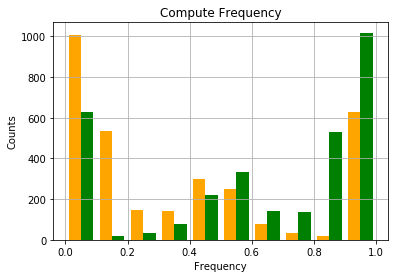

In [63]:
x = P150_df['AF']
reference = 1 - P150_df['AF']

plt.xlabel('Frequency')
plt.ylabel('Counts')
plt.title('Compute Frequency')
plt.grid(True)

plt.hist([x, reference], color=['orange', 'green']) 
plt.show()

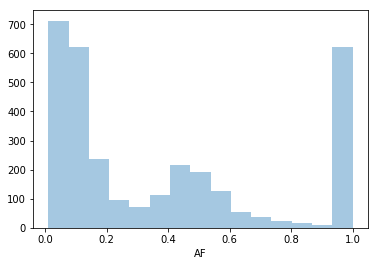

In [64]:
x = P150_df['AF']
espejo = 1 - P150_df['AF']

sns.distplot(x, kde=False, rug=False)
#sns.distplot(espejo, kde=False, rug=False)

In [65]:
P150_df['AF'].mean(axis = 0) 

0.387087770184361

In [66]:
def scatter_vcf(vcf_df):
    y = vcf_df['AF'][vcf_df['AF'] < 1]
    x = vcf_df['AF'][vcf_df['AF'] < 1].index.values
    
    mean = vcf_df['AF'].mean(axis = 0)
    
    col_mean = np.where(vcf_df['AF'][vcf_df['AF'] < 1] > mean,'c','r')
    
    plt.figure(figsize=(50,20))
    plt.margins(x=0.01, y=0.01, tight=True)

    plt.xlabel('Frequency')
    plt.ylabel('Counts')
    plt.title('Compute Frequency')
    plt.grid(True)
    

    plt.scatter(x, y, color=col_mean, alpha=0.5, s=200) # colormap='jet'
    plt.show()
    

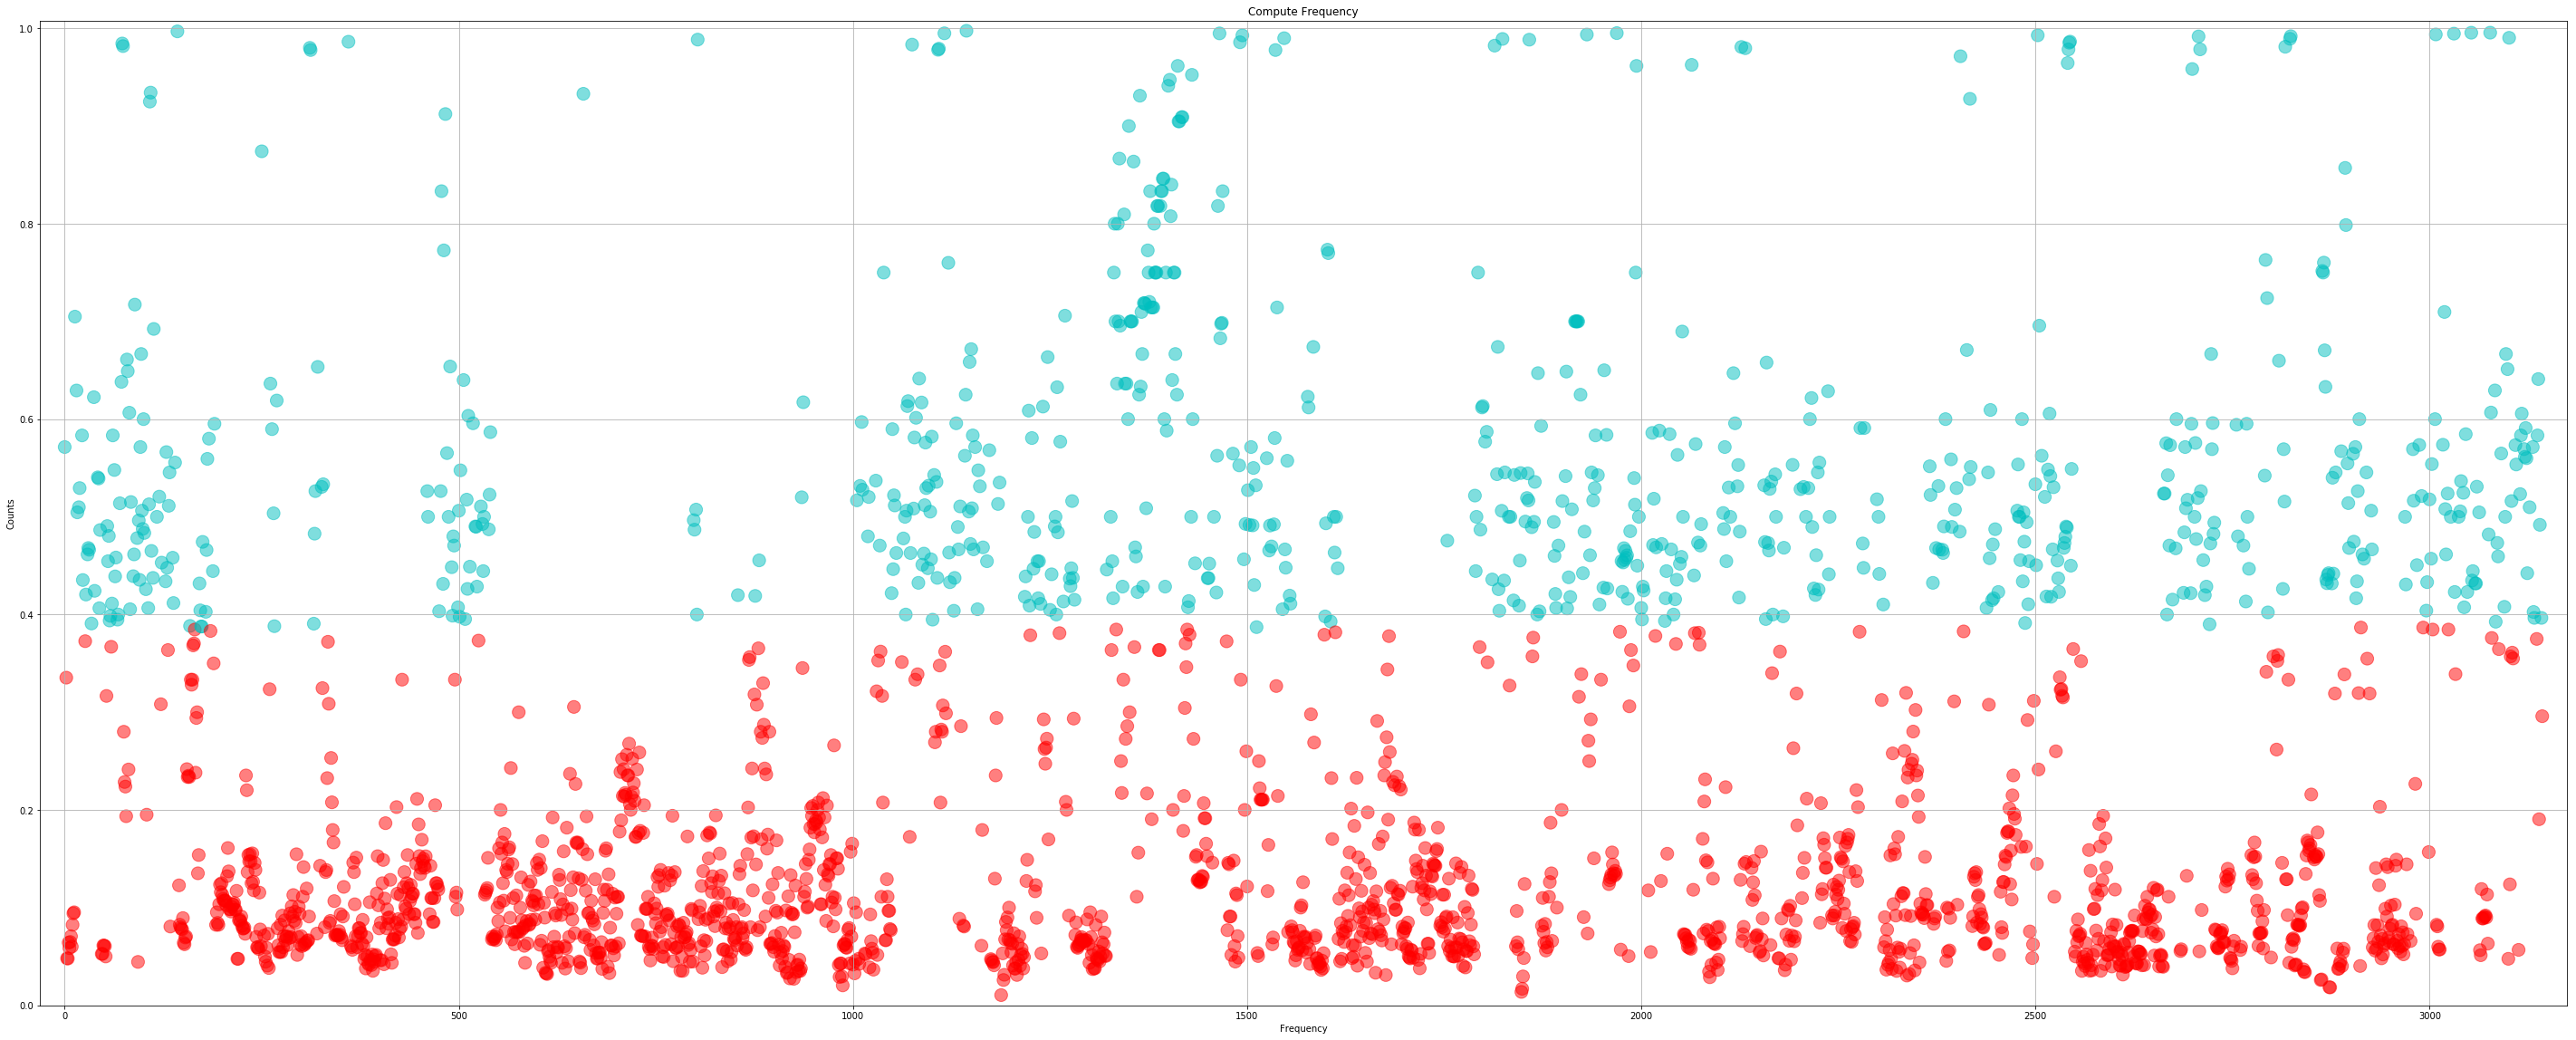

In [67]:
scatter_vcf(P150_df)

# FILTER REPEATS

In [31]:
list_positions = []
with open("data/repeats_annot.coords.tab") as f:
    for _ in range(1):
        next(f)
    for line in f:
        split_line = line.strip().split("\t")
        expression = "((row['POS'] >= %s) & (row['POS'] <= %s))" % (split_line[0], split_line[1])
        list_positions.append(expression)
print("(" + "|".join(list_positions) + ")")

(((row['POS'] >= 33582 ) & (row['POS'] <=  33794))|((row['POS'] >= 103710 ) & (row['POS'] <=  104663))|((row['POS'] >= 104805 ) & (row['POS'] <=  105215))|((row['POS'] >= 105324 ) & (row['POS'] <=  106715))|((row['POS'] >= 131382 ) & (row['POS'] <=  132872))|((row['POS'] >= 149533 ) & (row['POS'] <=  150996))|((row['POS'] >= 177543 ) & (row['POS'] <=  179309))|((row['POS'] >= 179319 ) & (row['POS'] <=  180896))|((row['POS'] >= 187433 ) & (row['POS'] <=  188839))|((row['POS'] >= 188931 ) & (row['POS'] <=  190439))|((row['POS'] >= 307877 ) & (row['POS'] <=  309547))|((row['POS'] >= 333437 ) & (row['POS'] <=  336310))|((row['POS'] >= 336560 ) & (row['POS'] <=  339073))|((row['POS'] >= 339364 ) & (row['POS'] <=  340974))|((row['POS'] >= 349624 ) & (row['POS'] <=  349932))|((row['POS'] >= 349935 ) & (row['POS'] <=  351476))|((row['POS'] >= 361334 ) & (row['POS'] <=  363109))|((row['POS'] >= 366150 ) & (row['POS'] <=  372764))|((row['POS'] >= 372820 ) & (row['POS'] <=  375711))|((row['POS'] 

In [46]:
def filter_repeats(row):
    if ((row['POS'] >= 33582 ) & (row['POS'] <=  33794))|((row['POS'] >= 103710 ) & (row['POS'] <=  104663))|((row['POS'] >= 104805 ) & (row['POS'] <=  105215))|((row['POS'] >= 105324 ) & (row['POS'] <=  106715))|((row['POS'] >= 131382 ) & (row['POS'] <=  132872))|((row['POS'] >= 149533 ) & (row['POS'] <=  150996))|((row['POS'] >= 177543 ) & (row['POS'] <=  179309))|((row['POS'] >= 179319 ) & (row['POS'] <=  180896))|((row['POS'] >= 187433 ) & (row['POS'] <=  188839))|((row['POS'] >= 188931 ) & (row['POS'] <=  190439))|((row['POS'] >= 307877 ) & (row['POS'] <=  309547))|((row['POS'] >= 333437 ) & (row['POS'] <=  336310))|((row['POS'] >= 336560 ) & (row['POS'] <=  339073))|((row['POS'] >= 339364 ) & (row['POS'] <=  340974))|((row['POS'] >= 349624 ) & (row['POS'] <=  349932))|((row['POS'] >= 349935 ) & (row['POS'] <=  351476))|((row['POS'] >= 361334 ) & (row['POS'] <=  363109))|((row['POS'] >= 366150 ) & (row['POS'] <=  372764))|((row['POS'] >= 372820 ) & (row['POS'] <=  375711))|((row['POS'] >= 399535 ) & (row['POS'] <=  400050))|((row['POS'] >= 400192 ) & (row['POS'] <=  401703))|((row['POS'] >= 424269 ) & (row['POS'] <=  424694))|((row['POS'] >= 424777 ) & (row['POS'] <=  434679))|((row['POS'] >= 466672 ) & (row['POS'] <=  467406))|((row['POS'] >= 467459 ) & (row['POS'] <=  468001))|((row['POS'] >= 472781 ) & (row['POS'] <=  474106))|((row['POS'] >= 475816 ) & (row['POS'] <=  476184))|((row['POS'] >= 530751 ) & (row['POS'] <=  532214))|((row['POS'] >= 543174 ) & (row['POS'] <=  544730))|((row['POS'] >= 606551 ) & (row['POS'] <=  608062))|((row['POS'] >= 622793 ) & (row['POS'] <=  624577))|((row['POS'] >= 671996 ) & (row['POS'] <=  675916))|((row['POS'] >= 832534 ) & (row['POS'] <=  832848))|((row['POS'] >= 832981 ) & (row['POS'] <=  833508))|((row['POS'] >= 835701 ) & (row['POS'] <=  838052))|((row['POS'] >= 838451 ) & (row['POS'] <=  840856))|((row['POS'] >= 846159 ) & (row['POS'] <=  847913))|((row['POS'] >= 848103 ) & (row['POS'] <=  850040))|((row['POS'] >= 850342 ) & (row['POS'] <=  850527))|((row['POS'] >= 889072 ) & (row['POS'] <=  889398))|((row['POS'] >= 889395 ) & (row['POS'] <=  890333))|((row['POS'] >= 890388 ) & (row['POS'] <=  891482))|((row['POS'] >= 924951 ) & (row['POS'] <=  925364))|((row['POS'] >= 925361 ) & (row['POS'] <=  927610))|((row['POS'] >= 927837 ) & (row['POS'] <=  930485))|((row['POS'] >= 947312 ) & (row['POS'] <=  947644))|((row['POS'] >= 968424 ) & (row['POS'] <=  970244))|((row['POS'] >= 976872 ) & (row['POS'] <=  978203))|((row['POS'] >= 1020058 ) & (row['POS'] <=  1021329))|((row['POS'] >= 1021344 ) & (row['POS'] <=  1021643))|((row['POS'] >= 1025497 ) & (row['POS'] <=  1026816))|((row['POS'] >= 1027104 ) & (row['POS'] <=  1027685))|((row['POS'] >= 1027685 ) & (row['POS'] <=  1029337))|((row['POS'] >= 1090373 ) & (row['POS'] <=  1093144))|((row['POS'] >= 1093361 ) & (row['POS'] <=  1094356))|((row['POS'] >= 1095078 ) & (row['POS'] <=  1096451))|((row['POS'] >= 1158918 ) & (row['POS'] <=  1159307))|((row['POS'] >= 1159375 ) & (row['POS'] <=  1160061))|((row['POS'] >= 1161297 ) & (row['POS'] <=  1162472))|((row['POS'] >= 1162549 ) & (row['POS'] <=  1163376))|((row['POS'] >= 1164572 ) & (row['POS'] <=  1165435))|((row['POS'] >= 1165092 ) & (row['POS'] <=  1165499))|((row['POS'] >= 1169423 ) & (row['POS'] <=  1170670))|((row['POS'] >= 1176928 ) & (row['POS'] <=  1177242))|((row['POS'] >= 1188421 ) & (row['POS'] <=  1190424))|((row['POS'] >= 1190757 ) & (row['POS'] <=  1192148))|((row['POS'] >= 1211560 ) & (row['POS'] <=  1213863))|((row['POS'] >= 1214513 ) & (row['POS'] <=  1214947))|((row['POS'] >= 1214769 ) & (row['POS'] <=  1215131))|((row['POS'] >= 1216469 ) & (row['POS'] <=  1219030))|((row['POS'] >= 1251617 ) & (row['POS'] <=  1252972))|((row['POS'] >= 1262272 ) & (row['POS'] <=  1264128))|((row['POS'] >= 1276300 ) & (row['POS'] <=  1277748))|((row['POS'] >= 1277893 ) & (row['POS'] <=  1278300))|((row['POS'] >= 1298764 ) & (row['POS'] <=  1299804))|((row['POS'] >= 1299822 ) & (row['POS'] <=  1300124))|((row['POS'] >= 1301755 ) & (row['POS'] <=  1302681))|((row['POS'] >= 1339003 ) & (row['POS'] <=  1339302))|((row['POS'] >= 1339349 ) & (row['POS'] <=  1340524))|((row['POS'] >= 1341358 ) & (row['POS'] <=  1342605))|((row['POS'] >= 1357293 ) & (row['POS'] <=  1357625))|((row['POS'] >= 1384989 ) & (row['POS'] <=  1386677))|((row['POS'] >= 1468171 ) & (row['POS'] <=  1469505))|((row['POS'] >= 1488154 ) & (row['POS'] <=  1489965))|((row['POS'] >= 1532443 ) & (row['POS'] <=  1533633))|((row['POS'] >= 1541994 ) & (row['POS'] <=  1542878))|((row['POS'] >= 1542929 ) & (row['POS'] <=  1543255))|((row['POS'] >= 1561464 ) & (row['POS'] <=  1561772))|((row['POS'] >= 1561769 ) & (row['POS'] <=  1563388))|((row['POS'] >= 1572127 ) & (row['POS'] <=  1573857))|((row['POS'] >= 1606386 ) & (row['POS'] <=  1607972))|((row['POS'] >= 1618209 ) & (row['POS'] <=  1619684))|((row['POS'] >= 1630638 ) & (row['POS'] <=  1634627))|((row['POS'] >= 1636004 ) & (row['POS'] <=  1638229))|((row['POS'] >= 1655609 ) & (row['POS'] <=  1656721))|((row['POS'] >= 1751297 ) & (row['POS'] <=  1753333))|((row['POS'] >= 1779194 ) & (row['POS'] <=  1779298))|((row['POS'] >= 1779314 ) & (row['POS'] <=  1779724))|((row['POS'] >= 1779930 ) & (row['POS'] <=  1780241))|((row['POS'] >= 1780199 ) & (row['POS'] <=  1780699))|((row['POS'] >= 1780643 ) & (row['POS'] <=  1782064))|((row['POS'] >= 1782072 ) & (row['POS'] <=  1782584))|((row['POS'] >= 1782758 ) & (row['POS'] <=  1783228))|((row['POS'] >= 1783309 ) & (row['POS'] <=  1783623))|((row['POS'] >= 1783620 ) & (row['POS'] <=  1783892))|((row['POS'] >= 1783906 ) & (row['POS'] <=  1784301))|((row['POS'] >= 1784497 ) & (row['POS'] <=  1785912))|((row['POS'] >= 1785912 ) & (row['POS'] <=  1786310))|((row['POS'] >= 1786307 ) & (row['POS'] <=  1786528))|((row['POS'] >= 1786584 ) & (row['POS'] <=  1787099))|((row['POS'] >= 1787096 ) & (row['POS'] <=  1788505))|((row['POS'] >= 1788162 ) & (row['POS'] <=  1789163))|((row['POS'] >= 1789168 ) & (row['POS'] <=  1789836))|((row['POS'] >= 1855764 ) & (row['POS'] <=  1856696))|((row['POS'] >= 1862347 ) & (row['POS'] <=  1865382))|((row['POS'] >= 1931497 ) & (row['POS'] <=  1932654))|((row['POS'] >= 1932694 ) & (row['POS'] <=  1933878))|((row['POS'] >= 1981614 ) & (row['POS'] <=  1984775))|((row['POS'] >= 1987745 ) & (row['POS'] <=  1988629))|((row['POS'] >= 1988680 ) & (row['POS'] <=  1989006))|((row['POS'] >= 1989833 ) & (row['POS'] <=  1992577))|((row['POS'] >= 1996152 ) & (row['POS'] <=  1996478))|((row['POS'] >= 1996529 ) & (row['POS'] <=  1997413))|((row['POS'] >= 1999142 ) & (row['POS'] <=  1999357)):
        return True
    elif ((row['POS'] >= 2000614 ) & (row['POS'] <=  2002470))|((row['POS'] >= 2025301 ) & (row['POS'] <=  2026398))|((row['POS'] >= 2026477 ) & (row['POS'] <=  2026776))|((row['POS'] >= 2026790 ) & (row['POS'] <=  2027971))|((row['POS'] >= 2028425 ) & (row['POS'] <=  2029477))|((row['POS'] >= 2029904 ) & (row['POS'] <=  2030203))|((row['POS'] >= 2039453 ) & (row['POS'] <=  2041420))|((row['POS'] >= 2042001 ) & (row['POS'] <=  2043272))|((row['POS'] >= 2043384 ) & (row['POS'] <=  2044775))|((row['POS'] >= 2044923 ) & (row['POS'] <=  2046842))|((row['POS'] >= 2048072 ) & (row['POS'] <=  2048371))|((row['POS'] >= 2048398 ) & (row['POS'] <=  2049597))|((row['POS'] >= 2049921 ) & (row['POS'] <=  2051150))|((row['POS'] >= 2051282 ) & (row['POS'] <=  2052688))|((row['POS'] >= 2061178 ) & (row['POS'] <=  2062674))|((row['POS'] >= 2087971 ) & (row['POS'] <=  2089518))|((row['POS'] >= 2162932 ) & (row['POS'] <=  2167311))|((row['POS'] >= 2167649 ) & (row['POS'] <=  2170612))|((row['POS'] >= 2195989 ) & (row['POS'] <=  2197353))|((row['POS'] >= 2226244 ) & (row['POS'] <=  2227920))|((row['POS'] >= 2260665 ) & (row['POS'] <=  2261144))|((row['POS'] >= 2261098 ) & (row['POS'] <=  2261688))|((row['POS'] >= 2358389 ) & (row['POS'] <=  2360041))|((row['POS'] >= 2365465 ) & (row['POS'] <=  2365791))|((row['POS'] >= 2365788 ) & (row['POS'] <=  2366726))|((row['POS'] >= 2367359 ) & (row['POS'] <=  2367655))|((row['POS'] >= 2367711 ) & (row['POS'] <=  2368442))|((row['POS'] >= 2381071 ) & (row['POS'] <=  2382492))|((row['POS'] >= 2387202 ) & (row['POS'] <=  2387972))|((row['POS'] >= 2423240 ) & (row['POS'] <=  2424838))|((row['POS'] >= 2430159 ) & (row['POS'] <=  2431199))|((row['POS'] >= 2431094 ) & (row['POS'] <=  2431420))|((row['POS'] >= 2439282 ) & (row['POS'] <=  2439947))|((row['POS'] >= 2550065 ) & (row['POS'] <=  2550391))|((row['POS'] >= 2550388 ) & (row['POS'] <=  2551326))|((row['POS'] >= 2600731 ) & (row['POS'] <=  2601879))|((row['POS'] >= 2617667 ) & (row['POS'] <=  2618908))|((row['POS'] >= 2632923 ) & (row['POS'] <=  2634098))|((row['POS'] >= 2634528 ) & (row['POS'] <=  2635592))|((row['POS'] >= 2635628 ) & (row['POS'] <=  2635954))|((row['POS'] >= 2635951 ) & (row['POS'] <=  2636889))|((row['POS'] >= 2637688 ) & (row['POS'] <=  2639535))|((row['POS'] >= 2651753 ) & (row['POS'] <=  2651938))|((row['POS'] >= 2692799 ) & (row['POS'] <=  2693884))|((row['POS'] >= 2706017 ) & (row['POS'] <=  2706736))|((row['POS'] >= 2720776 ) & (row['POS'] <=  2721777))|((row['POS'] >= 2727336 ) & (row['POS'] <=  2727920))|((row['POS'] >= 2727967 ) & (row['POS'] <=  2728266))|((row['POS'] >= 2784657 ) & (row['POS'] <=  2785697))|((row['POS'] >= 2785592 ) & (row['POS'] <=  2785918))|((row['POS'] >= 2795301 ) & (row['POS'] <=  2797385))|((row['POS'] >= 2801254 ) & (row['POS'] <=  2806236))|((row['POS'] >= 2828556 ) & (row['POS'] <=  2829803))|((row['POS'] >= 2835785 ) & (row['POS'] <=  2837263))|((row['POS'] >= 2921551 ) & (row['POS'] <=  2923182))|((row['POS'] >= 2935046 ) & (row['POS'] <=  2936788))|((row['POS'] >= 2943600 ) & (row['POS'] <=  2944985))|((row['POS'] >= 2960105 ) & (row['POS'] <=  2962441))|((row['POS'] >= 2970551 ) & (row['POS'] <=  2971549))|((row['POS'] >= 2972160 ) & (row['POS'] <=  2972486))|((row['POS'] >= 2972435 ) & (row['POS'] <=  2973421))|((row['POS'] >= 2973795 ) & (row['POS'] <=  2975234))|((row['POS'] >= 2975242 ) & (row['POS'] <=  2975775))|((row['POS'] >= 2975928 ) & (row['POS'] <=  2976554))|((row['POS'] >= 2976586 ) & (row['POS'] <=  2976909))|((row['POS'] >= 2976989 ) & (row['POS'] <=  2977234))|((row['POS'] >= 2977231 ) & (row['POS'] <=  2978658))|((row['POS'] >= 2978660 ) & (row['POS'] <=  2979052))|((row['POS'] >= 2979049 ) & (row['POS'] <=  2979309))|((row['POS'] >= 2979326 ) & (row['POS'] <=  2979688))|((row['POS'] >= 2979691 ) & (row['POS'] <=  2980818))|((row['POS'] >= 2983071 ) & (row['POS'] <=  2983874))|((row['POS'] >= 3053914 ) & (row['POS'] <=  3055491))|((row['POS'] >= 3076894 ) & (row['POS'] <=  3078078))|((row['POS'] >= 3078158 ) & (row['POS'] <=  3078985))|((row['POS'] >= 3079309 ) & (row['POS'] <=  3080457))|((row['POS'] >= 3100202 ) & (row['POS'] <=  3101581))|((row['POS'] >= 3115741 ) & (row['POS'] <=  3116142))|((row['POS'] >= 3116818 ) & (row['POS'] <=  3118227))|((row['POS'] >= 3120566 ) & (row['POS'] <=  3121504))|((row['POS'] >= 3121501 ) & (row['POS'] <=  3121827))|((row['POS'] >= 3162268 ) & (row['POS'] <=  3164115))|((row['POS'] >= 3194166 ) & (row['POS'] <=  3195548))|((row['POS'] >= 3200794 ) & (row['POS'] <=  3202020))|((row['POS'] >= 3288464 ) & (row['POS'] <=  3289705))|((row['POS'] >= 3289705 ) & (row['POS'] <=  3290235))|((row['POS'] >= 3289790 ) & (row['POS'] <=  3290506))|((row['POS'] >= 3313283 ) & (row['POS'] <=  3313672))|((row['POS'] >= 3333785 ) & (row['POS'] <=  3335164))|((row['POS'] >= 3376939 ) & (row['POS'] <=  3378243))|((row['POS'] >= 3378329 ) & (row['POS'] <=  3378415))|((row['POS'] >= 3379376 ) & (row['POS'] <=  3380452))|((row['POS'] >= 3380440 ) & (row['POS'] <=  3380682))|((row['POS'] >= 3380679 ) & (row['POS'] <=  3380993))|((row['POS'] >= 3381375 ) & (row['POS'] <=  3382622))|((row['POS'] >= 3465778 ) & (row['POS'] <=  3467091))|((row['POS'] >= 3481451 ) & (row['POS'] <=  3482698))|((row['POS'] >= 3490476 ) & (row['POS'] <=  3491651))|((row['POS'] >= 3501334 ) & (row['POS'] <=  3501732))|((row['POS'] >= 3501794 ) & (row['POS'] <=  3502936))|((row['POS'] >= 3510088 ) & (row['POS'] <=  3511317))|((row['POS'] >= 3527391 ) & (row['POS'] <=  3529163))|((row['POS'] >= 3551281 ) & (row['POS'] <=  3551607))|((row['POS'] >= 3551604 ) & (row['POS'] <=  3552542))|((row['POS'] >= 3552764 ) & (row['POS'] <=  3553090))|((row['POS'] >= 3553087 ) & (row['POS'] <=  3554025))|((row['POS'] >= 3557311 ) & (row['POS'] <=  3558345))|((row['POS'] >= 3710433 ) & (row['POS'] <=  3710759))|((row['POS'] >= 3710756 ) & (row['POS'] <=  3711694))|((row['POS'] >= 3711749 ) & (row['POS'] <=  3713461))|((row['POS'] >= 3729364 ) & (row['POS'] <=  3736935))|((row['POS'] >= 3736984 ) & (row['POS'] <=  3738438))|((row['POS'] >= 3738158 ) & (row['POS'] <=  3742774))|((row['POS'] >= 3743711 ) & (row['POS'] <=  3753184))|((row['POS'] >= 3753765 ) & (row['POS'] <=  3754256))|((row['POS'] >= 3754293 ) & (row['POS'] <=  3755033))|((row['POS'] >= 3755952 ) & (row['POS'] <=  3767102))|((row['POS'] >= 3778568 ) & (row['POS'] <=  3780334))|((row['POS'] >= 3795100 ) & (row['POS'] <=  3795984))|((row['POS'] >= 3796035 ) & (row['POS'] <=  3796361))|((row['POS'] >= 3800092 ) & (row['POS'] <=  3800796))|((row['POS'] >= 3800786 ) & (row['POS'] <=  3801463))|((row['POS'] >= 3801653 ) & (row['POS'] <=  3803848))|((row['POS'] >= 3842239 ) & (row['POS'] <=  3842769))|((row['POS'] >= 3843036 ) & (row['POS'] <=  3843734))|((row['POS'] >= 3843885 ) & (row['POS'] <=  3844640))|((row['POS'] >= 3844738 ) & (row['POS'] <=  3845970))|((row['POS'] >= 3847165 ) & (row['POS'] <=  3847701))|((row['POS'] >= 3883525 ) & (row['POS'] <=  3884193))|((row['POS'] >= 3883964 ) & (row['POS'] <=  3884917))|((row['POS'] >= 3890830 ) & (row['POS'] <=  3891156))|((row['POS'] >= 3891051 ) & (row['POS'] <=  3892091))|((row['POS'] >= 3894093 ) & (row['POS'] <=  3894389))|((row['POS'] >= 3894426 ) & (row['POS'] <=  3895607))|((row['POS'] >= 3926569 ) & (row['POS'] <=  3930714))|((row['POS'] >= 3931005 ) & (row['POS'] <=  3936710))|((row['POS'] >= 3939617 ) & (row['POS'] <=  3941761))|((row['POS'] >= 3941724 ) & (row['POS'] <=  3944963))|((row['POS'] >= 3945794 ) & (row['POS'] <=  3950263))|((row['POS'] >= 3969343 ) & (row['POS'] <=  3970563))|((row['POS'] >= 3970705 ) & (row['POS'] <=  3972453))|((row['POS'] >= 3978059 ) & (row['POS'] <=  3979498))|((row['POS'] >= 3997980 ) & (row['POS'] <=  3999638))|((row['POS'] >= 4031404 ) & (row['POS'] <=  4033158))|((row['POS'] >= 4036731 ) & (row['POS'] <=  4038050))|((row['POS'] >= 4060648 ) & (row['POS'] <=  4061889))|((row['POS'] >= 4061899 ) & (row['POS'] <=  4062198))|((row['POS'] >= 4075752 ) & (row['POS'] <=  4076099))|((row['POS'] >= 4076484 ) & (row['POS'] <=  4076984))|((row['POS'] >= 4076984 ) & (row['POS'] <=  4077730))|((row['POS'] >= 4091233 ) & (row['POS'] <=  4091517))|((row['POS'] >= 4093632 ) & (row['POS'] <=  4093946))|((row['POS'] >= 4093940 ) & (row['POS'] <=  4094527))|((row['POS'] >= 4189285 ) & (row['POS'] <=  4190232))|((row['POS'] >= 4190284 ) & (row['POS'] <=  4190517))|((row['POS'] >= 4196171 ) & (row['POS'] <=  4196506))|((row['POS'] >= 4198874 ) & (row['POS'] <=  4199089))|((row['POS'] >= 4252993 ) & (row['POS'] <=  4254327))|((row['POS'] >= 4276571 ) & (row['POS'] <=  4278085))|((row['POS'] >= 4301563 ) & (row['POS'] <=  4302789))|((row['POS'] >= 4318775 ) & (row['POS'] <=  4319266))|((row['POS'] >= 4350745 ) & (row['POS'] <=  4351044))|((row['POS'] >= 4351075 ) & (row['POS'] <=  4352181))|((row['POS'] >= 4374484 ) & (row['POS'] <=  4375683))|((row['POS'] >= 4375762 ) & (row['POS'] <=  4375995)):
        return True
    else:
        return False

In [68]:
P150_df.head()

#CHROM   POS ID REF ALT  QUAL FILTER  \
0  MTB_anc  1977  .   G   A   190   PASS   
1  MTB_anc  2532  .   C   T  3926   PASS   
2  MTB_anc  6140  .   G   T  1262   PASS   
3  MTB_anc  6769  .   C   T   140   PASS   
4  MTB_anc  6775  .   G   T   134   PASS   

                                      INFO     DP        AF   SB          DP4  \
0       DP=14;AF=0.571429;SB=0;DP4=4,1,6,2   14.0  0.571429  0.0      4,1,6,2   
1    DP=136;AF=1.000000;SB=0;DP4=0,0,72,64  136.0  1.000000  0.0    0,0,72,64   
2  DP=164;AF=0.335366;SB=0;DP4=57,52,28,27  164.0  0.335366  0.0  57,52,28,27   
3    DP=187;AF=0.048128;SB=1;DP4=93,85,4,5  187.0  0.048128  1.0    93,85,4,5   
4    DP=188;AF=0.047872;SB=1;DP4=91,86,4,5  188.0  0.047872  1.0    91,86,4,5   

   Fref  Rref  Fsample  Rsample  
0   4.0   1.0      6.0      2.0  
1   0.0   0.0     72.0     64.0  
2  57.0  52.0     28.0     27.0  
3  93.0  85.0      4.0      5.0  
4  91.0  86.0      4.0      5.0

## Apply repeat info

In [70]:
P150_df['Is_repeat'] = P150_df.apply(filter_repeats, axis=1)
P180_df['Is_repeat'] = P180_df.apply(filter_repeats, axis=1)
P190_df['Is_repeat'] = P190_df.apply(filter_repeats, axis=1)

In [116]:
P150_df_nr = P150_df[P150_df['Is_repeat'] == False].reset_index(drop=True)
P180_df_nr = P180_df[P180_df['Is_repeat'] == False].reset_index(drop=True)
P190_df_nr = P190_df[P190_df['Is_repeat'] == False].reset_index(drop=True)

In [73]:
def scatter_vcf_pos(vcf_df):
    y = vcf_df['AF'][vcf_df['AF'] < 1]
    x = vcf_df['POS'][vcf_df['AF'] < 1]
    plt.figure(figsize=(100,25))
    plt.margins(x=0.01, y=0.01, tight=True)
    
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    
    col_mean = np.where(vcf_df['AF'][vcf_df['AF'] < 1] > mean,'c','salmon')

    plt.xlabel('Frequency')
    plt.ylabel('Counts')
    plt.title('Compute Frequency')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='1', color='k')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='1', color='k')
    
    # Turn on/off the display of all ticks.
    plt.tick_params(which='minor', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='on') # turn on bottom ticks
    plt.grid(True)

    plt.scatter(x, y, color=col_mean, alpha=0.5, s=300)
    plt.show()

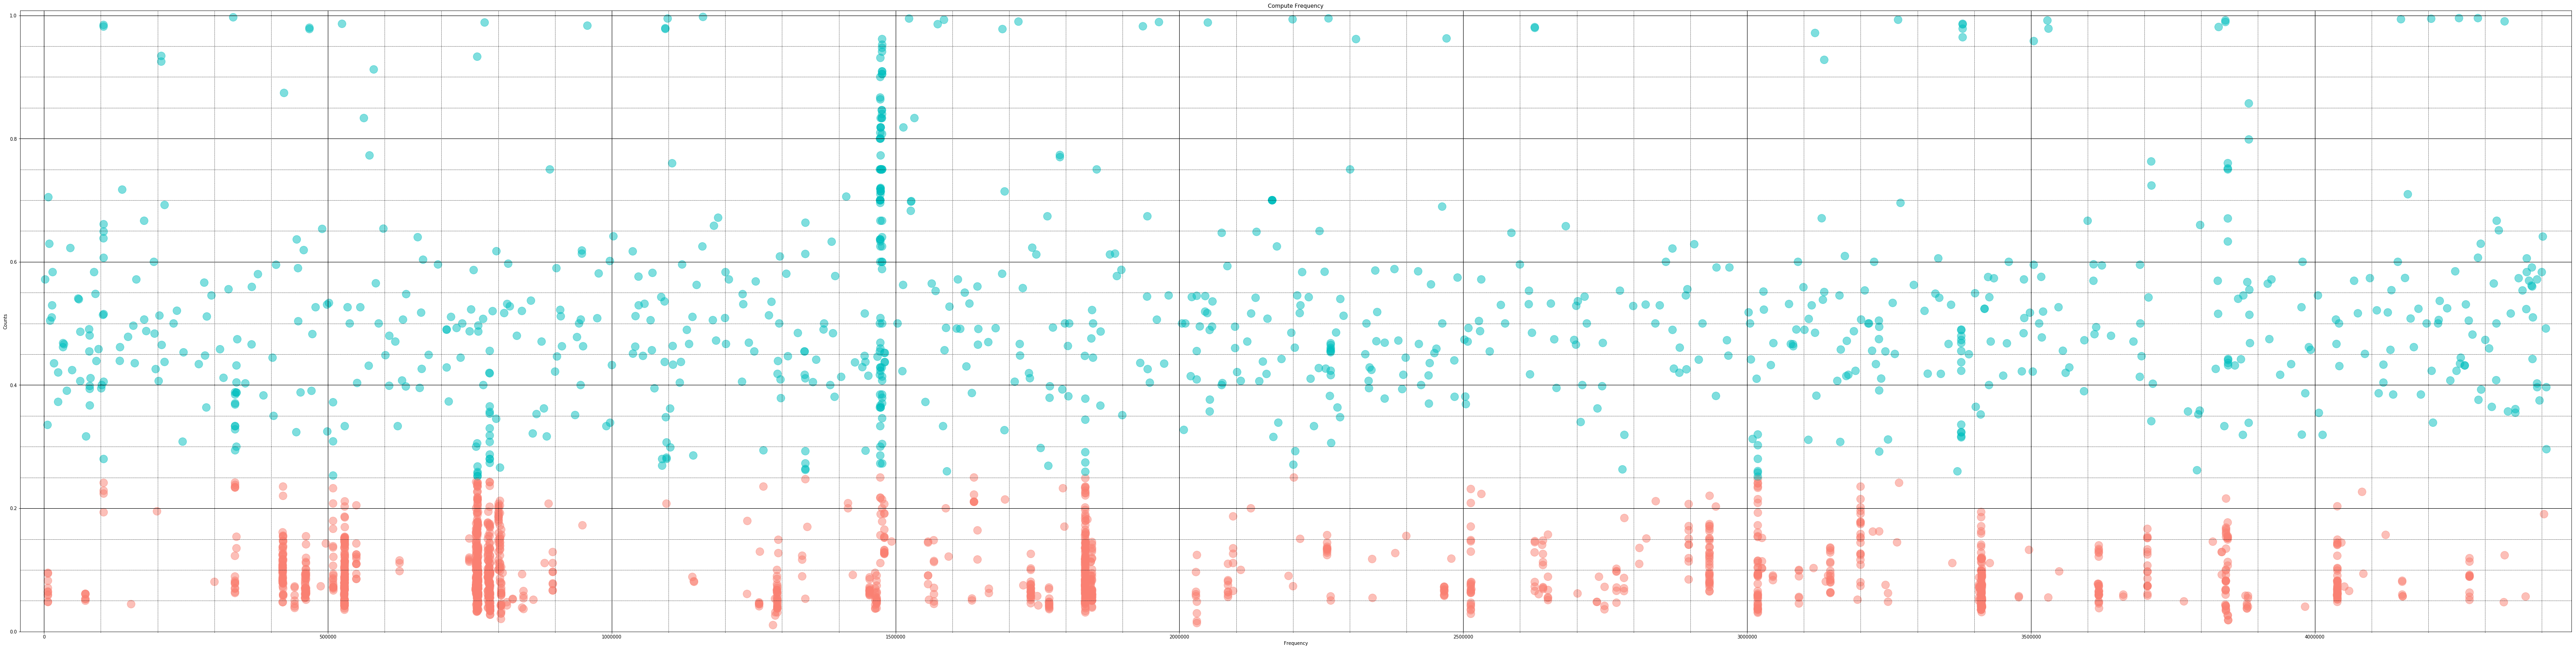

In [129]:
scatter_vcf_pos(P150_df)

In [69]:
P150_df.shape

(3146, 16)

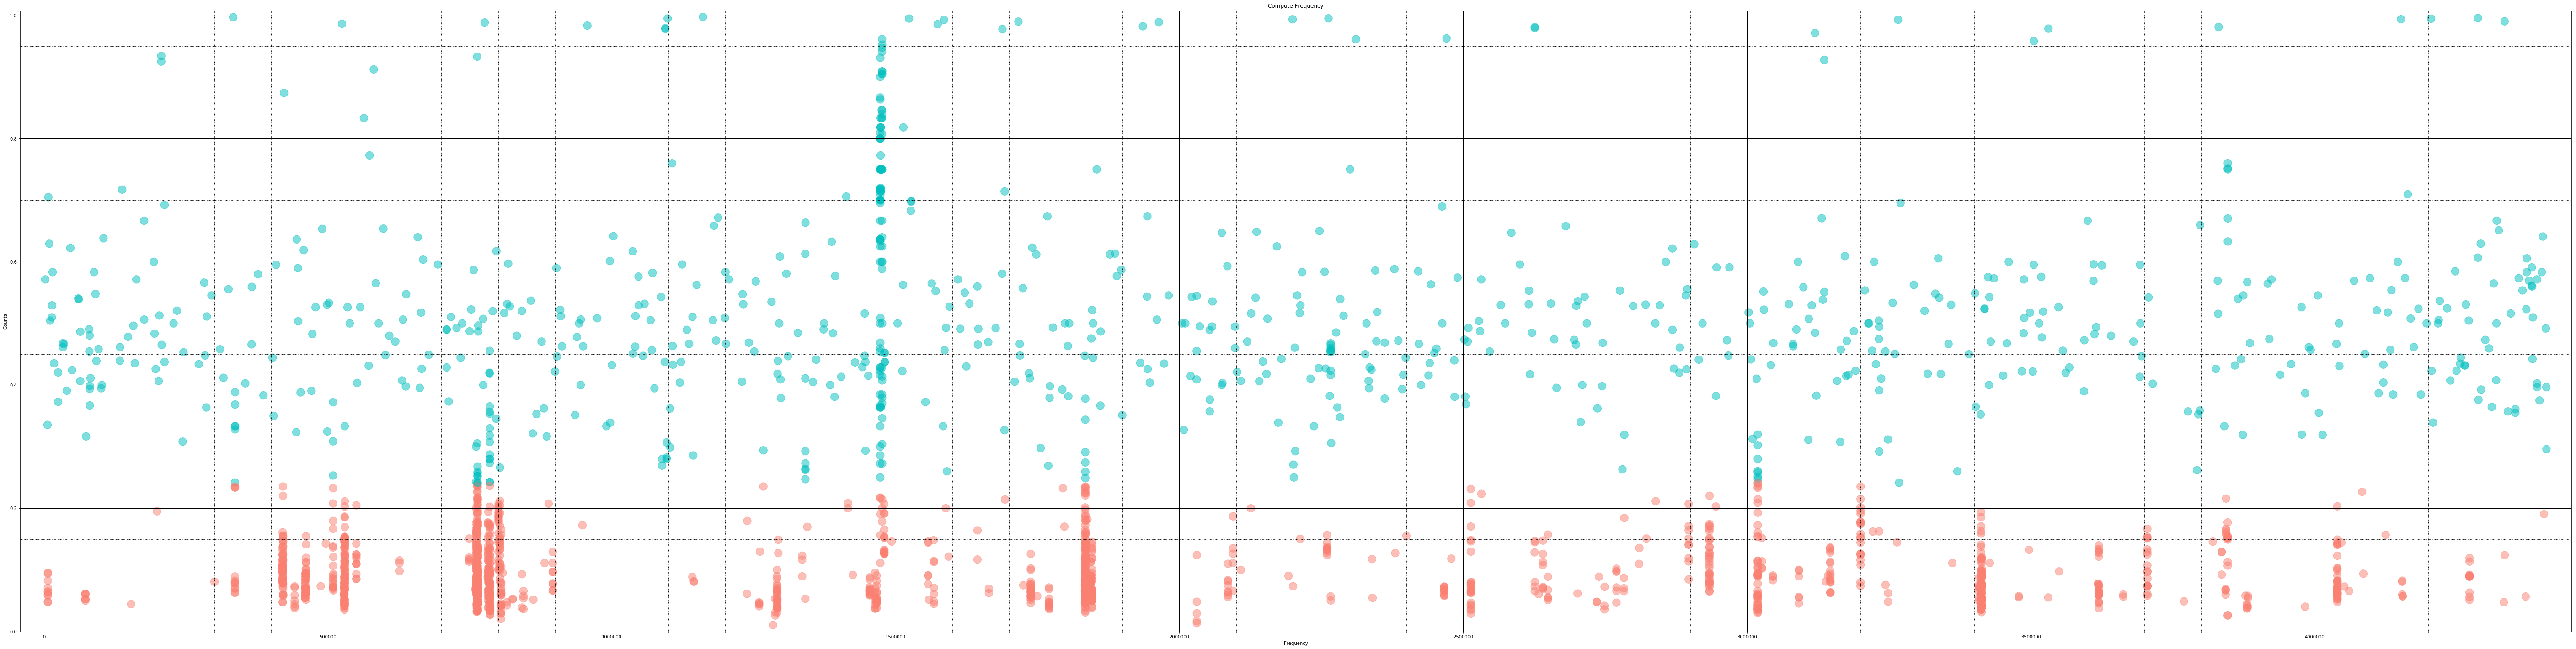

In [76]:
scatter_vcf_pos(P150_df_nr)

In [77]:
P150_df_nr.shape

(2957, 17)

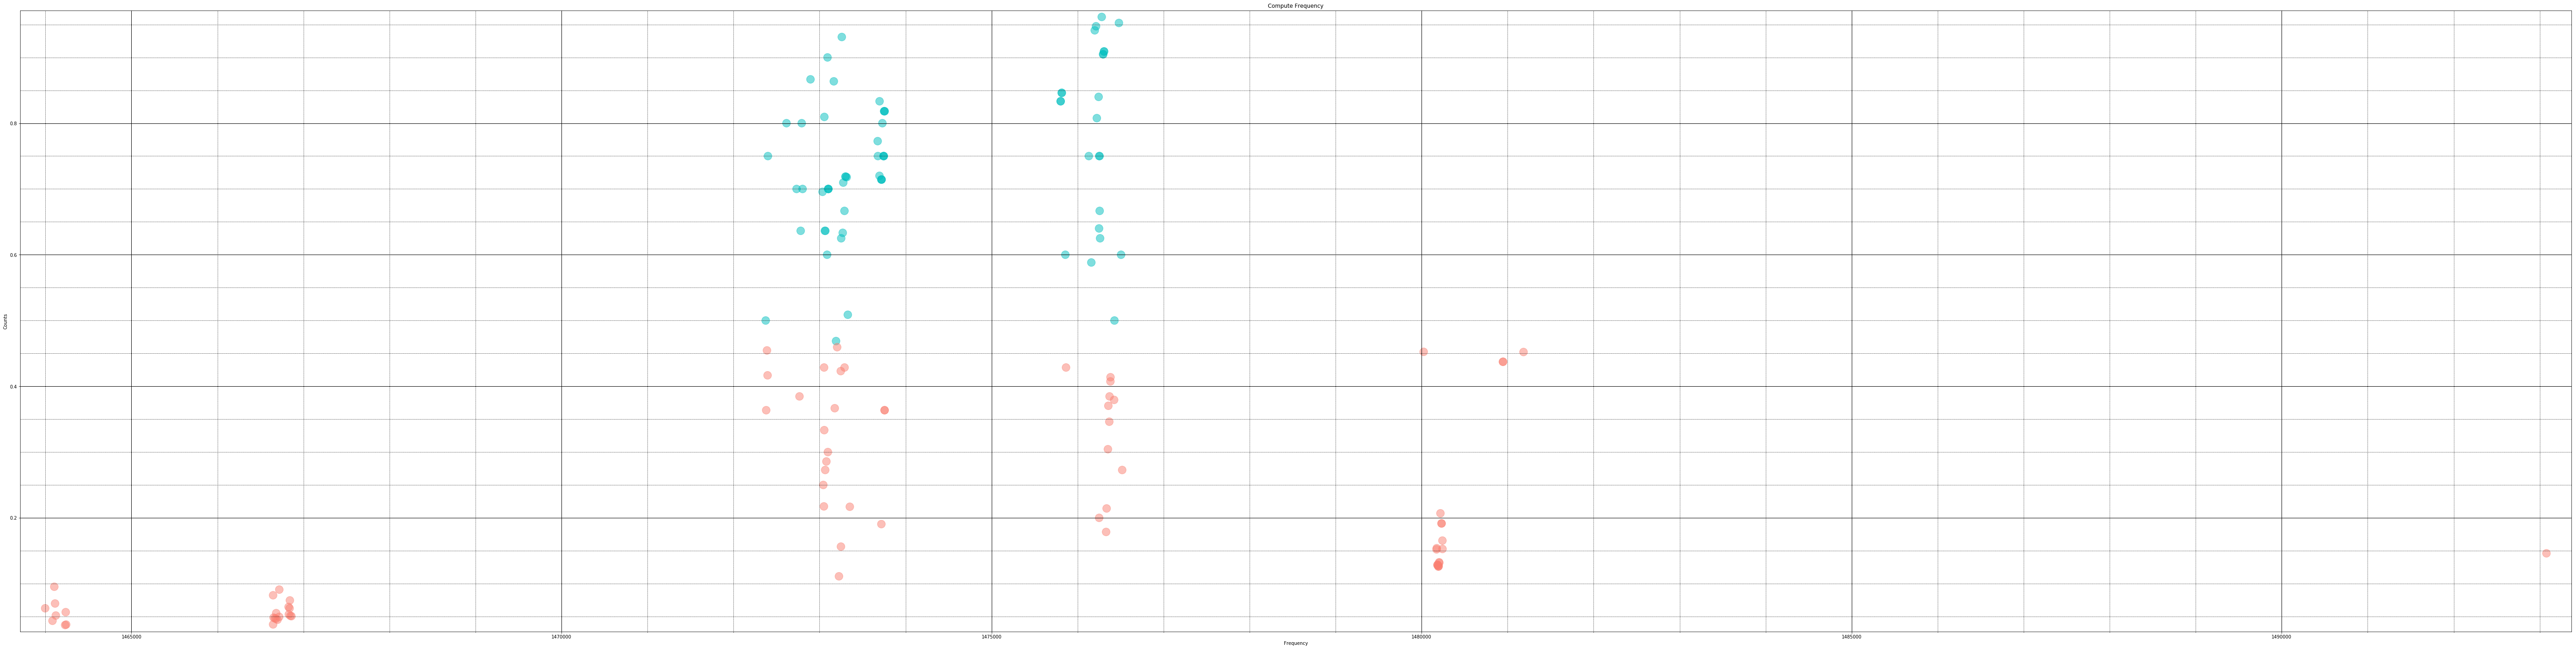

In [88]:
scatter_vcf_pos(P150_df_nr[(P150_df_nr['POS'] > 1460000) & (P150_df_nr['POS'] < 1500000)])

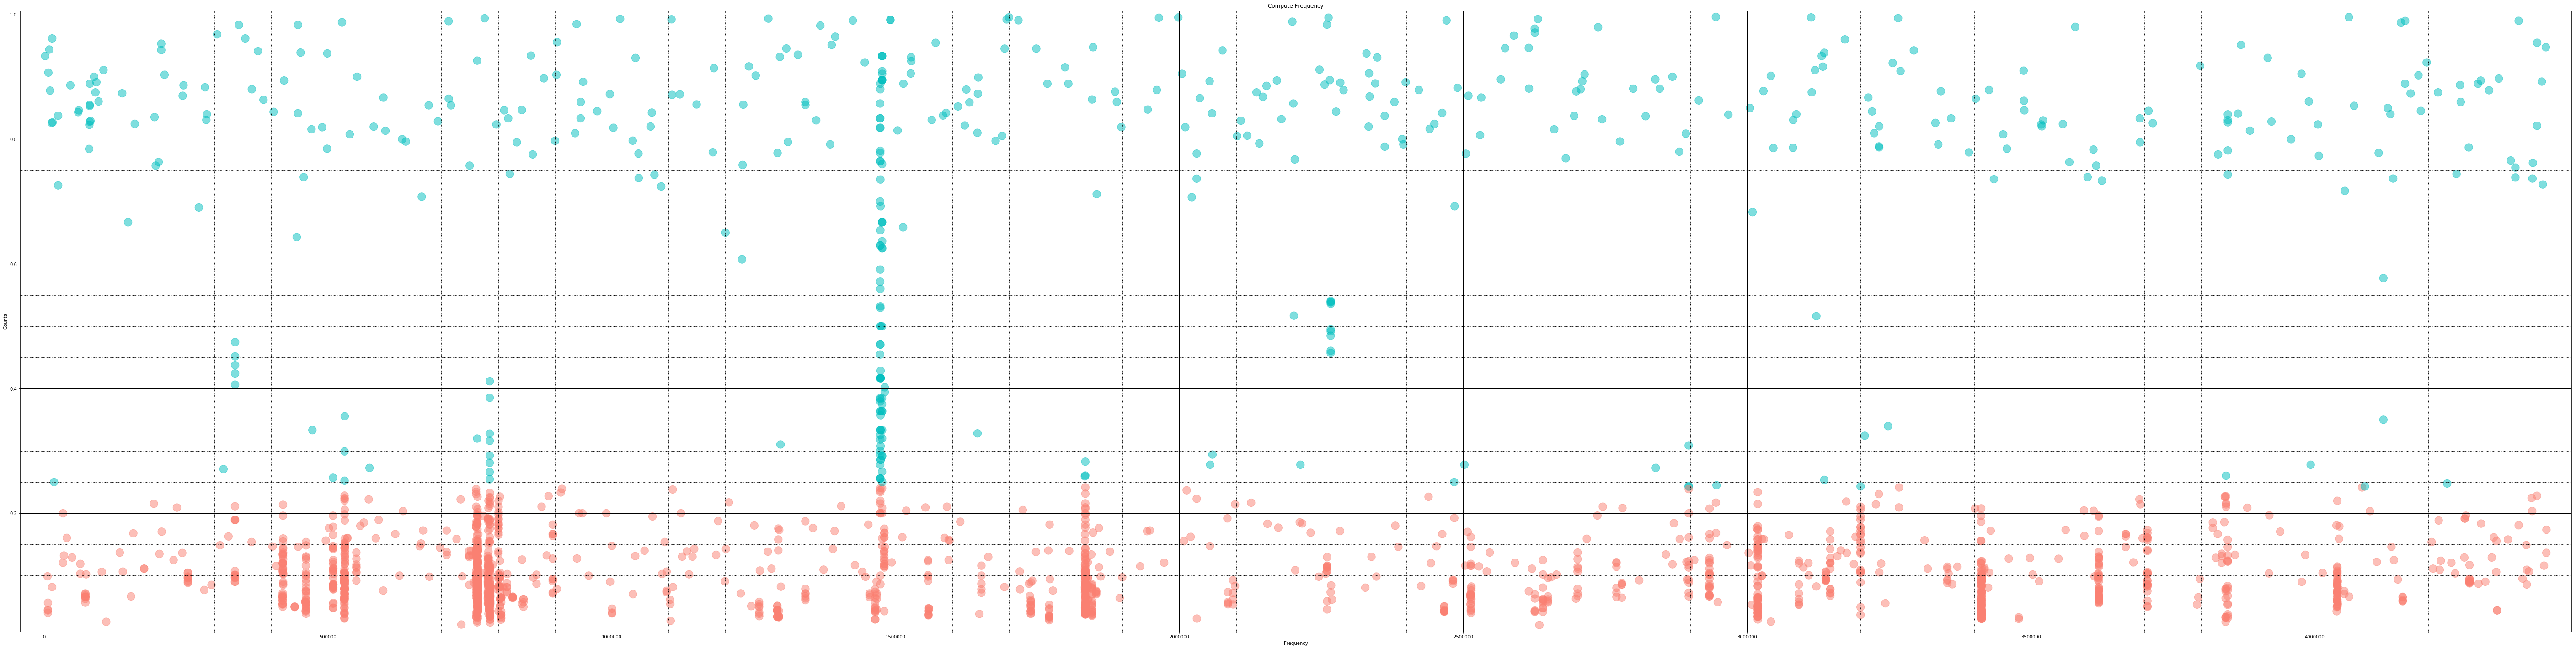

In [90]:
scatter_vcf_pos(P180_df_nr)

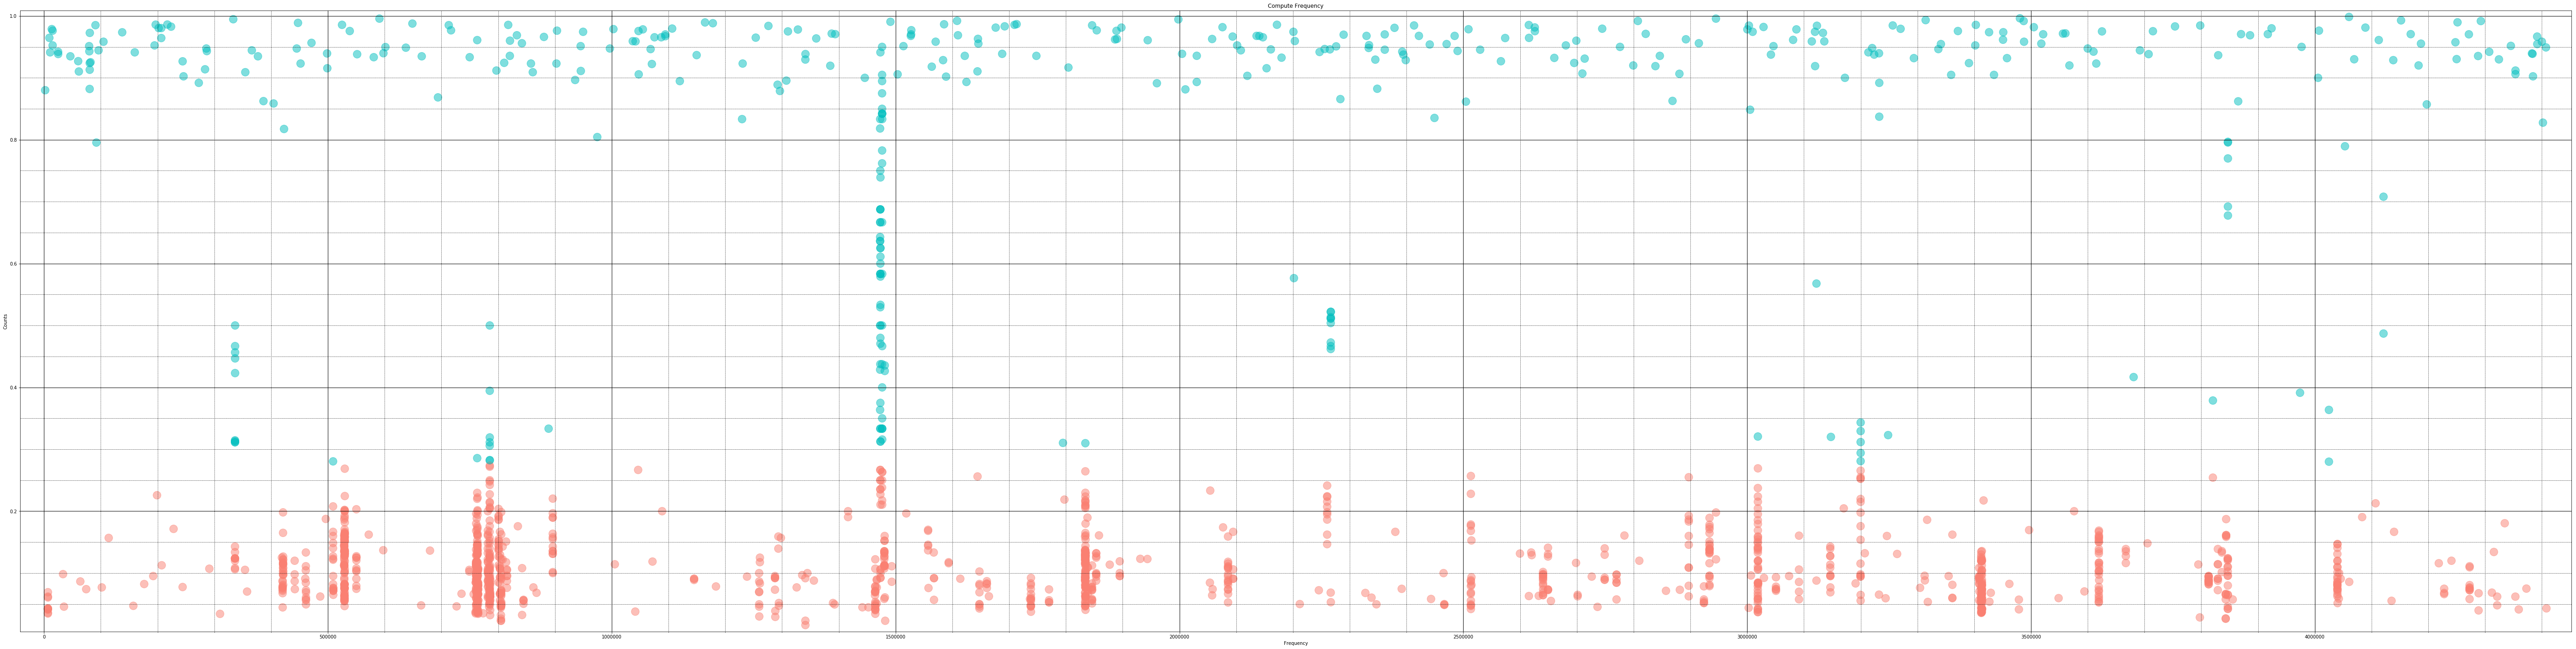

In [91]:
scatter_vcf_pos(P190_df_nr)

In [66]:
def create_bin(bin, max):
    for i in range(1, max, bin):
        print(i,i+bin-1)

In [92]:
print(len(P180_df_nr.index.values))

2775


In [93]:
print(P180_df_nr.loc[2955,'POS'])

4408156


In [117]:
def add_snp_distance(vcf_df):
    for index in vcf_df.index.values:
        if index > 0:
            vcf_df.loc[index,'snp_left_distance'] = vcf_df.loc[index,'POS'] - vcf_df.loc[index - 1,'POS']
        if index < (len(vcf_df.index.values) - 1):
            vcf_df.loc[index,'snp_right_distance'] = vcf_df.loc[index + 1,'POS'] - vcf_df.loc[index,'POS']
            
    return vcf_df

In [118]:
#P190_df_nr[P190_df_nr.isnull().any(axis=1)]

In [119]:
P190_df_nr_ds = add_snp_distance(P190_df_nr)
P180_df_nr_ds = add_snp_distance(P180_df_nr)
P150_df_nr_ds = add_snp_distance(P150_df_nr)

In [120]:
P180_df_nr_ds.tail()

#CHROM      POS ID REF ALT  QUAL FILTER  \
2770  MTB_anc  4407588  .   C   T  4934   PASS   
2771  MTB_anc  4407970  .   G   A   645   PASS   
2772  MTB_anc  4408156  .   A   C   376   PASS   
2773  MTB_anc  4408920  .   G   A  2293   PASS   
2774  MTB_anc  4408923  .   T   C  2677   PASS   

                                           INFO     DP        AF   SB  \
2770      DP=178;AF=1.000000;SB=0;DP4=0,0,93,85  178.0  1.000000  0.0   
2771  DP=249;AF=0.136546;SB=0;DP4=104,111,16,18  249.0  0.136546  0.0   
2772     DP=121;AF=0.173554;SB=0;DP4=34,66,6,15  121.0  0.173554  0.0   
2773       DP=84;AF=1.000000;SB=0;DP4=0,0,31,53   84.0  1.000000  0.0   
2774       DP=82;AF=1.000000;SB=0;DP4=0,0,30,52   82.0  1.000000  0.0   

                DP4   Fref   Rref  Fsample  Rsample  Is_repeat  \
2770      0,0,93,85    0.0    0.0     93.0     85.0      False   
2771  104,111,16,18  104.0  111.0     16.0     18.0      False   
2772     34,66,6,15   34.0   66.0      6.0     15.0      False   
2773      0,0,31,53    0.0    0.0     31.0     53.0      False   
2774      0,0,30,52    0.0    0.0     30.0     52.0      False   

      snp_right_distance  snp_left_distance  
2770               382.0              478.0  
2771               186.0              382.0  
2772               764.0              186.0  
2773                 3.0              764.0  
2774                 NaN                3.0

In [121]:
P180_df_nr_ds['snp_left_distance'].describe()

count     2774.000000
mean      1588.661139
std       3064.324001
min          0.000000
25%          5.000000
50%         27.000000
75%       1805.750000
max      28792.000000
Name: snp_left_distance, dtype: float64

In [122]:
def filter_by_distance(vcf_dist_df, distance):
    vcf_df_filtered_distance = vcf_dist_df[((vcf_dist_df['snp_right_distance'] > distance) | (vcf_dist_df['snp_left_distance'] > distance))]
    return vcf_df_filtered_distance

In [349]:
PAIR190_dsf = filter_by_distance(P190_df_nr_ds, 1500)
PAIR180_dsf = filter_by_distance(P180_df_nr_ds, 1500)
PAIR150_dsf = filter_by_distance(P150_df_nr_ds, 1500)

/home/laura/env36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


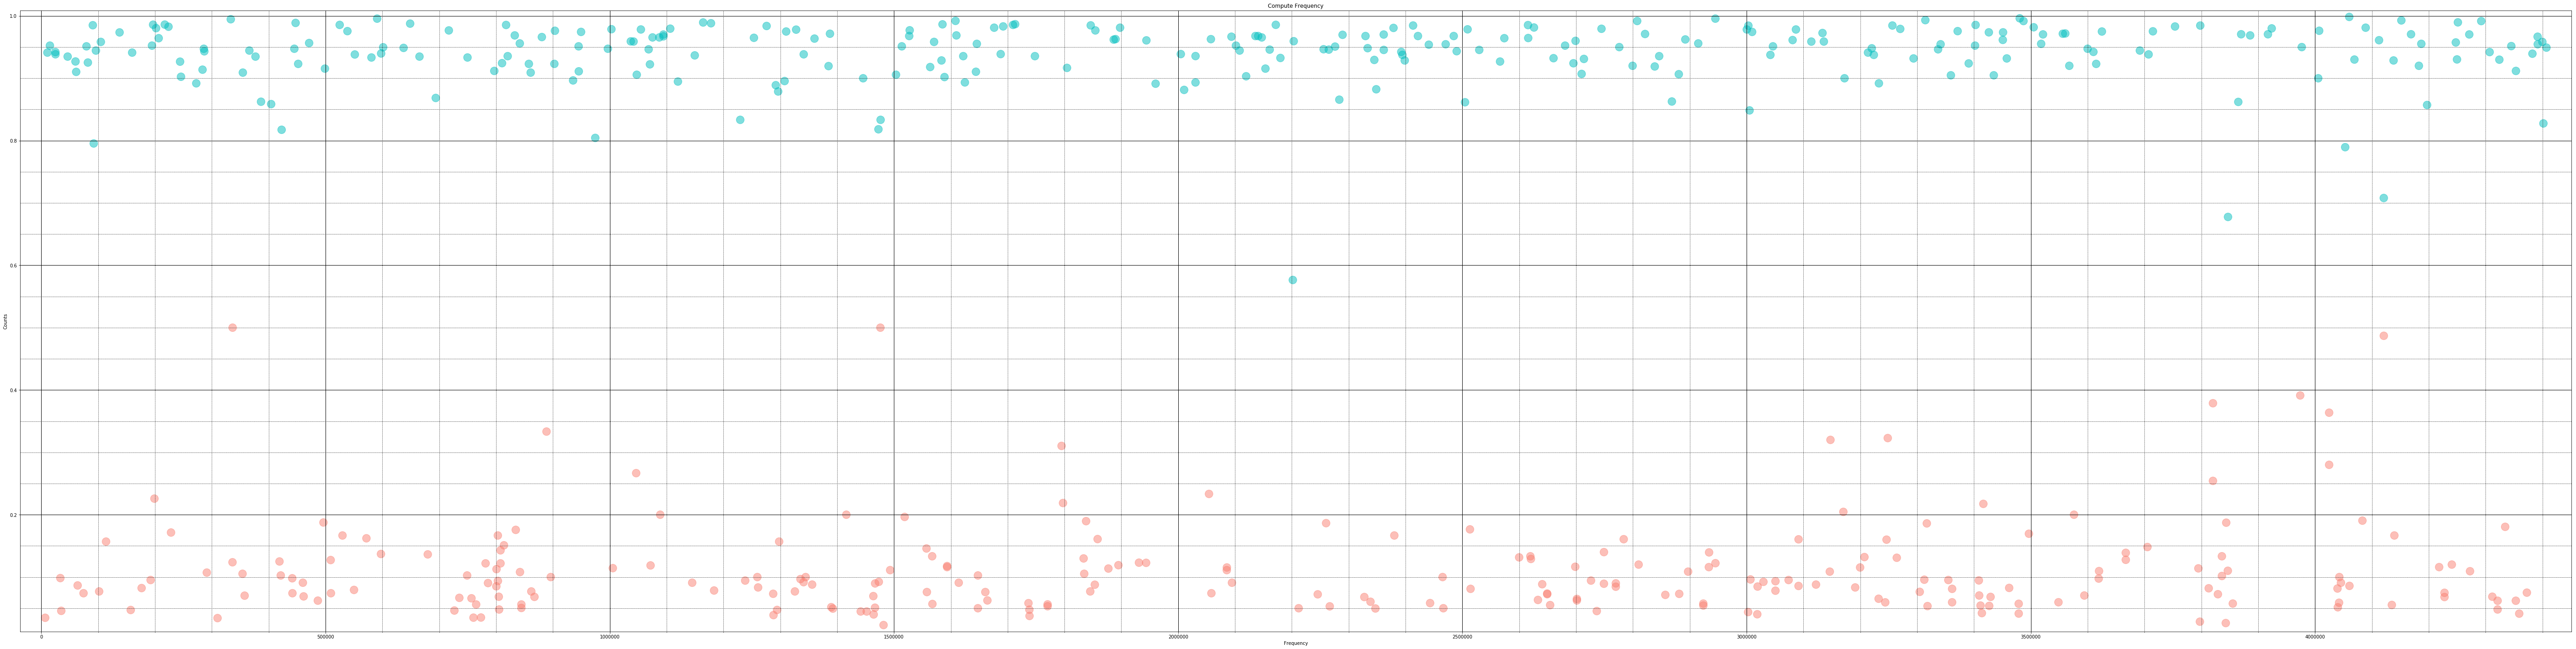

In [350]:
scatter_vcf_pos(PAIR190_dsf)

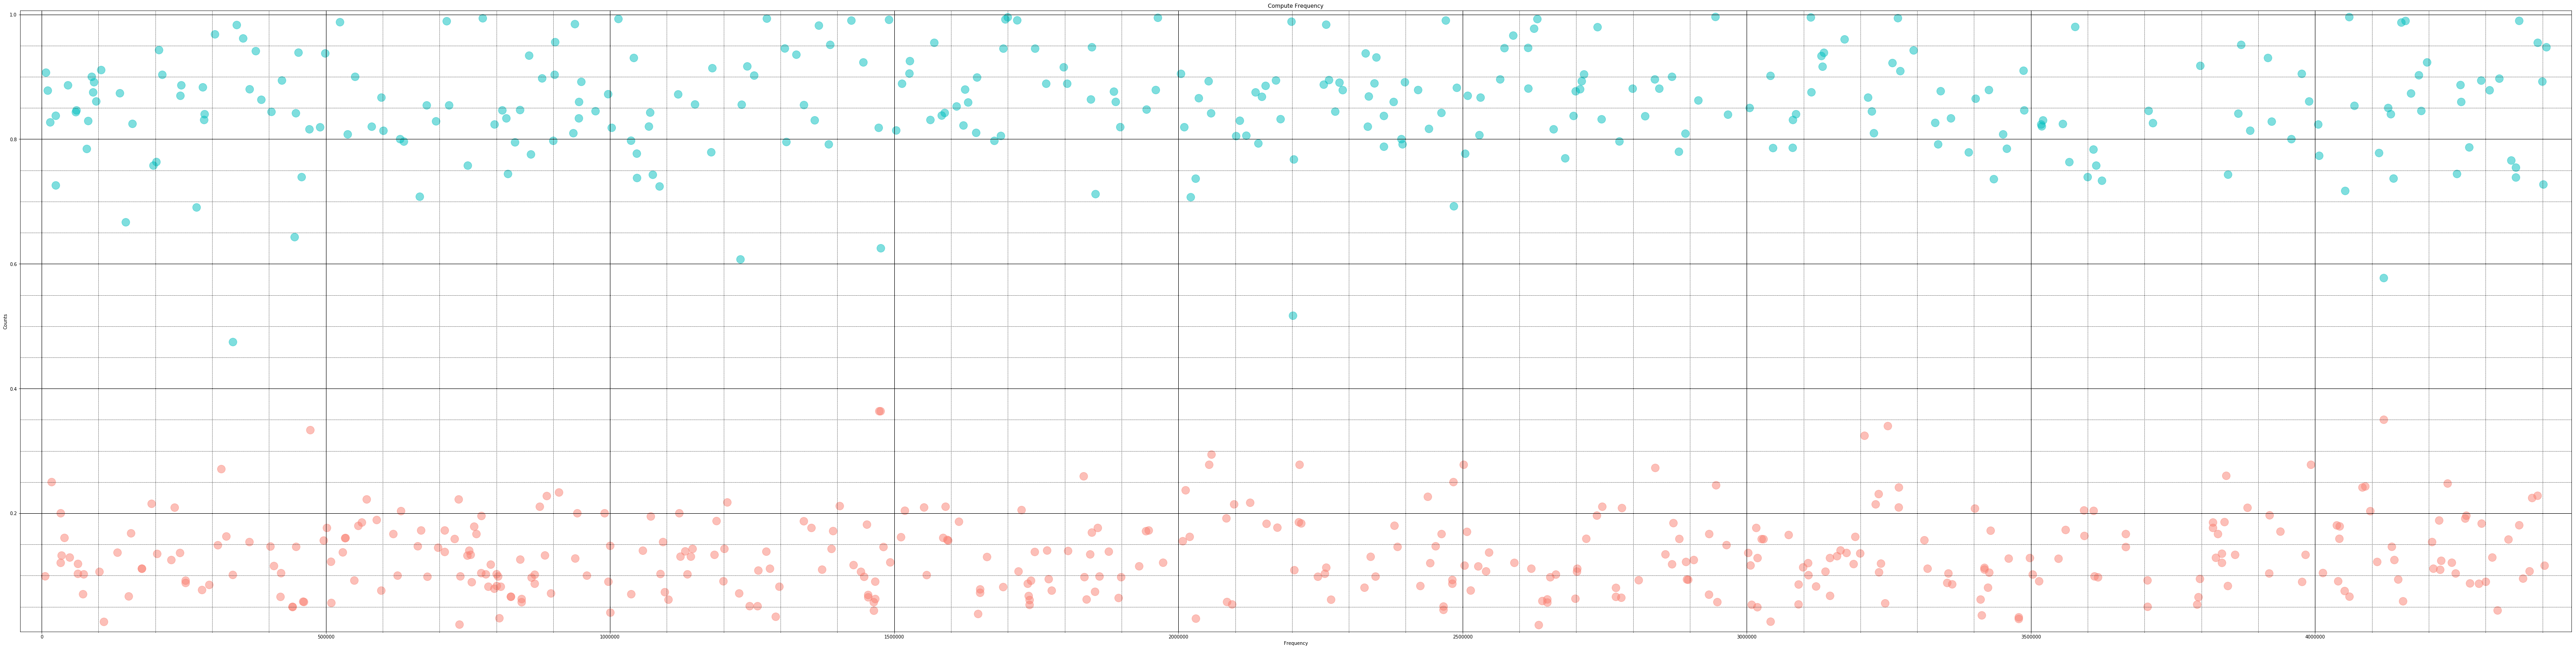

In [351]:
scatter_vcf_pos(PAIR180_dsf)

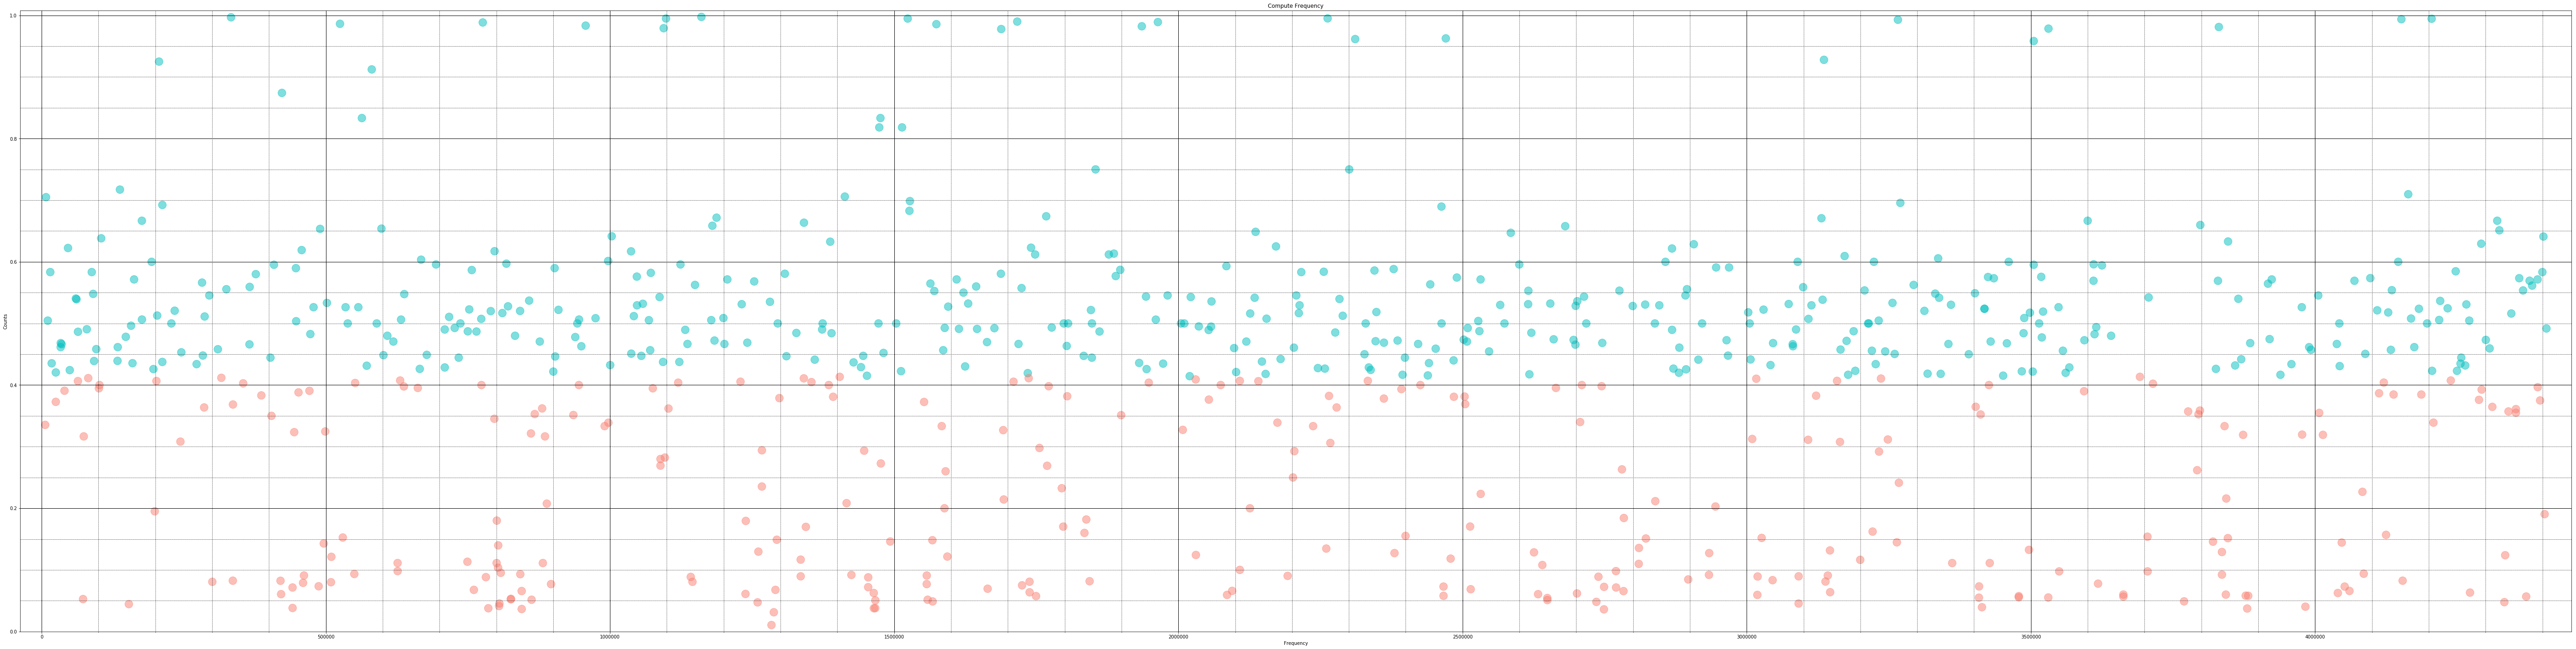

In [352]:
scatter_vcf_pos(PAIR150_dsf)

In [353]:
PAIR150_dsf['snp_right_distance'].dropna().describe()

count     1171.000000
mean      3612.727583
std       3626.019197
min          0.000000
25%       1084.000000
50%       2574.000000
75%       4990.000000
max      28792.000000
Name: snp_right_distance, dtype: float64

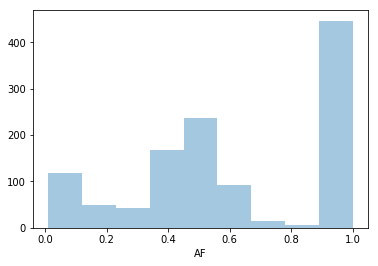

In [354]:
x = PAIR150_dsf['AF']
sns.distplot(x, kde=False, rug=False)

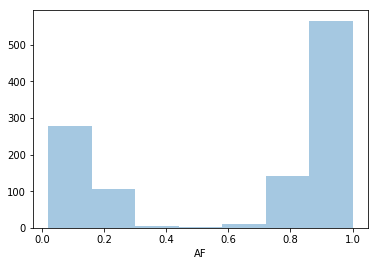

In [355]:
x = PAIR180_dsf['AF']
sns.distplot(x, kde=False, rug=False)

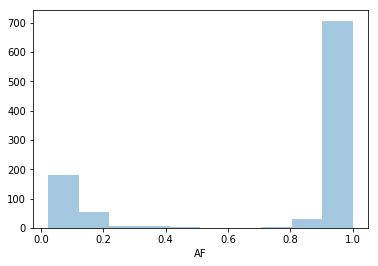

In [356]:
x = PAIR190_dsf['AF']
sns.distplot(x, kde=False, rug=False)

# Extract position by Allele Frequency

In [357]:
def split_df_mean(vcf_df):
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    top_positions = vcf_df['POS'][(vcf_df['AF'] > mean) & (vcf_df['AF'] < 1)].tolist()
    bottom_positions = vcf_df['POS'][vcf_df['AF'] < mean].tolist()
    return top_positions, bottom_positions

## B = Burgos
## P = Paredes

In [359]:
B_file = "data/BURGOS89109_S9_L001__final.bam.snp.final"
P_file = "data/56850173_S1_L001__final.bam.snp.final"

In [360]:
B_final = import_to_pandas(B_file)
P_final = import_to_pandas(P_file)

In [361]:
B_pos = set(B_final.loc[:,0].tolist())
P_pos = set(P_final.loc[:,0].tolist())

In [362]:
B_exclusive = B_pos - P_pos
P_exclusive = P_pos - B_pos
Shared_position = P_pos & B_pos

print("B has %s unique positions\n\
P has %s unique positions\n\
Both share %s positions" % (len(B_exclusive) , len(P_exclusive), len(Shared_position)))

B has 317 unique positions
P has 354 unique positions
Both share 539 positions


In [363]:
print(len(B_exclusive))

317


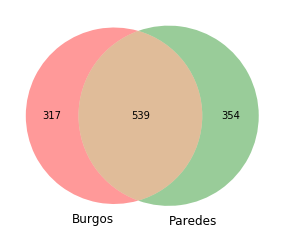

In [364]:
#venn2(subsets = (len(B_exclusive), len(P_exclusive), len(Shared_position)), set_labels = ('Burgos', 'Paredes'))
#plt.show()
venn2([B_pos, P_pos],  set_labels = ('Burgos', 'Paredes'))
plt.show()


# Check P80

In [365]:
top_P180, btm_P180 = split_df_mean(PAIR180_dsf)

In [358]:
print(len(top_P180))
print(len(btm_P180))

316
432


In [366]:
top_P180_set = set(top_P180)
btm_P180_set = set(btm_P180)

In [367]:
#Ven diagram with all (non exclusive snps in BURGOS)
#venn3([top_P180_set, btm_P180_set, B_pos], ('TOP', 'BTM', 'BURGOS'))
#plt.show()

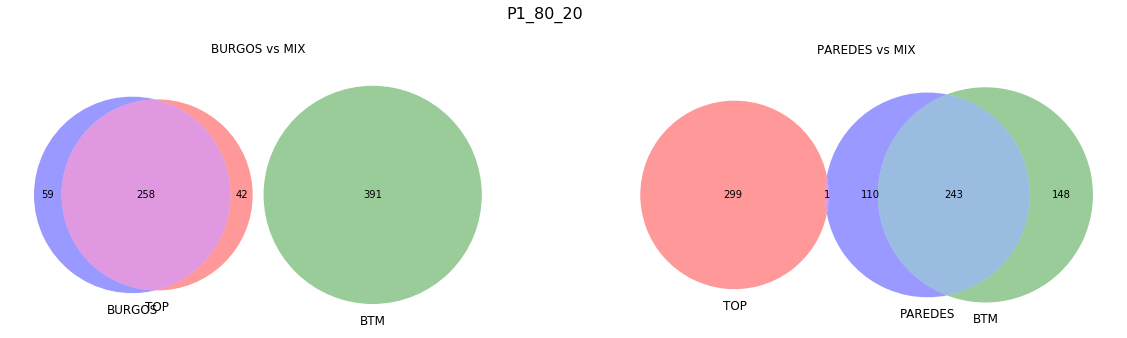

In [368]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("BURGOS vs MIX")
v = venn3([top_P180_set, btm_P180_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P180_set, btm_P180_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(1, 2, 2)
plt.title("PAREDES vs MIX")
v2 = venn3([top_P180_set, btm_P180_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.suptitle('P1_80_20', fontsize=16, verticalalignment='bottom')

plt.show()

In [379]:
print(len(B_exclusive))

317


In [369]:
#Ven diagram with all (non exclusive snps in PAREDES)
#venn3([top_P180_set, btm_P180_set, P_pos], ('TOP', 'BTM', 'PAREDES'))
#plt.show()

# Check P90

In [370]:
top_P190, btm_P190 = split_df_mean(PAIR190_dsf)
top_P190_set = set(top_P190)
btm_P190_set = set(btm_P190)

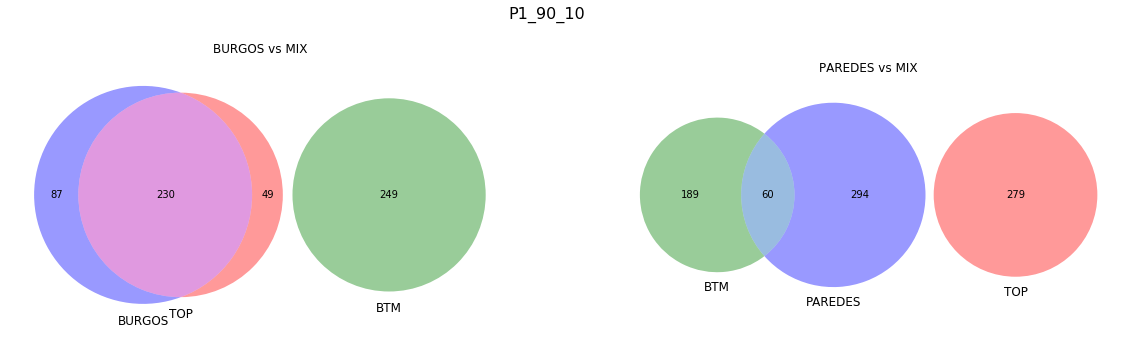

In [371]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("BURGOS vs MIX")
v = venn3([top_P190_set, btm_P190_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P190_set, btm_P190_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(1, 2, 2)
plt.title("PAREDES vs MIX")
v2 = venn3([top_P190_set, btm_P190_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.suptitle('P1_90_10', fontsize=16, verticalalignment='bottom')

plt.show()

# Check P50

In [372]:
top_P150, btm_P150 = split_df_mean(PAIR150_dsf)
top_P150_set = set(top_P150)
btm_P150_set = set(btm_P150)

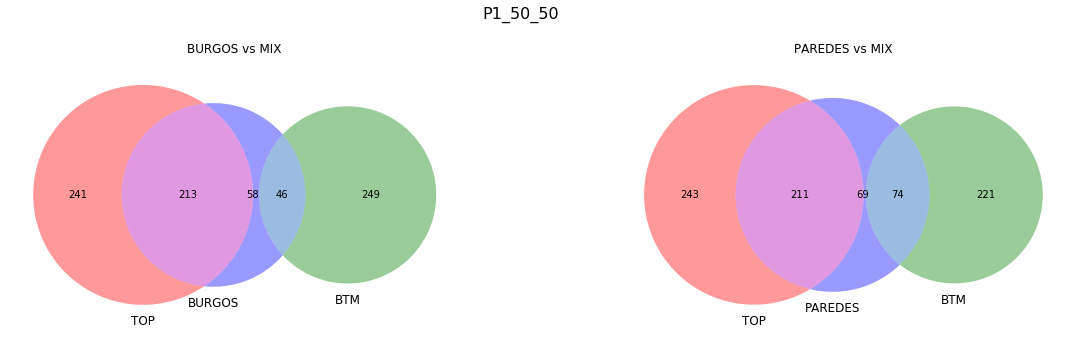

In [373]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("BURGOS vs MIX")
v = venn3([top_P150_set, btm_P150_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P150_set, btm_P150_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(1, 2, 2)
plt.title("PAREDES vs MIX")
v2 = venn3([top_P150_set, btm_P150_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.suptitle('P1_50_50', fontsize=16, verticalalignment='bottom')

plt.show()

# Use SNPs filtered by Laura

In [374]:
snp_B_P_Laura = pd.read_excel("data/SNPs_diferenciales_burgos_paredes.xlsx")

In [375]:
snp_B_P_Laura.head()

Position  56850173_S1_L001__final.bam.snp.final  \
0      1977                                      0   
1      6140                                      1   
2      7585                                      0   
3      9304                                      0   
4     10741                                      0   

   BURGOS89109_S9_L001__final.bam.snp.final  Sum  
0                                         1    1  
1                                         0    1  
2                                         1    1  
3                                         1    1  
4                                         1    1

In [376]:
B_exclusive_L = snp_B_P_Laura['Position'][snp_B_P_Laura['BURGOS89109_S9_L001__final.bam.snp.final'] == 1].tolist()
P_exclusive_L = snp_B_P_Laura['Position'][snp_B_P_Laura['56850173_S1_L001__final.bam.snp.final'] == 1].tolist()
B_exclusive_L_set = set(B_exclusive_L)
P_exclusive_L_set = set(P_exclusive_L)

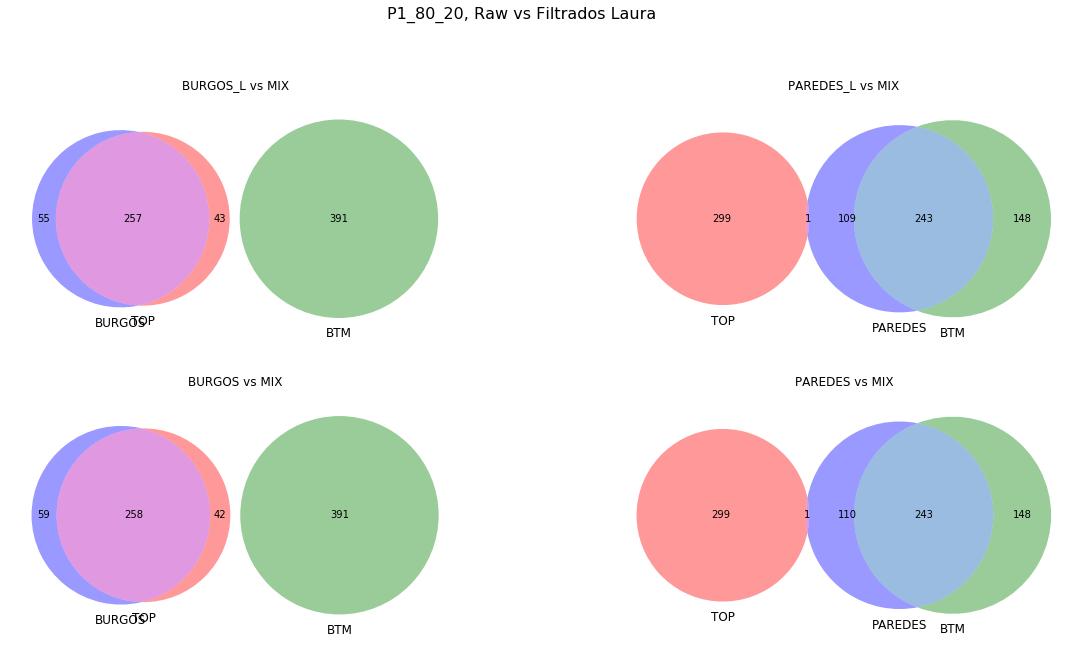

In [377]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.title("BURGOS_L vs MIX")
v = venn3([top_P180_set, btm_P180_set, B_exclusive_L_set], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P150_set, btm_P150_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(2, 2, 2)
plt.title("PAREDES_L vs MIX")
v2 = venn3([top_P180_set, btm_P180_set, P_exclusive_L_set], set_labels = ('TOP', 'BTM', 'PAREDES'))


plt.subplot(2, 2, 3)
plt.title("BURGOS vs MIX")
v = venn3([top_P180_set, btm_P180_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P180_set, btm_P180_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(2, 2, 4)
plt.title("PAREDES vs MIX")
v2 = venn3([top_P180_set, btm_P180_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))


plt.suptitle('P1_80_20, Raw vs Filtrados Laura', fontsize=16, verticalalignment='bottom')

plt.savefig(os.path.join('img', 'P1_80_20_RAW_LAU.svg'), format="svg")
#plt.show()

# FINAL COMPARISON

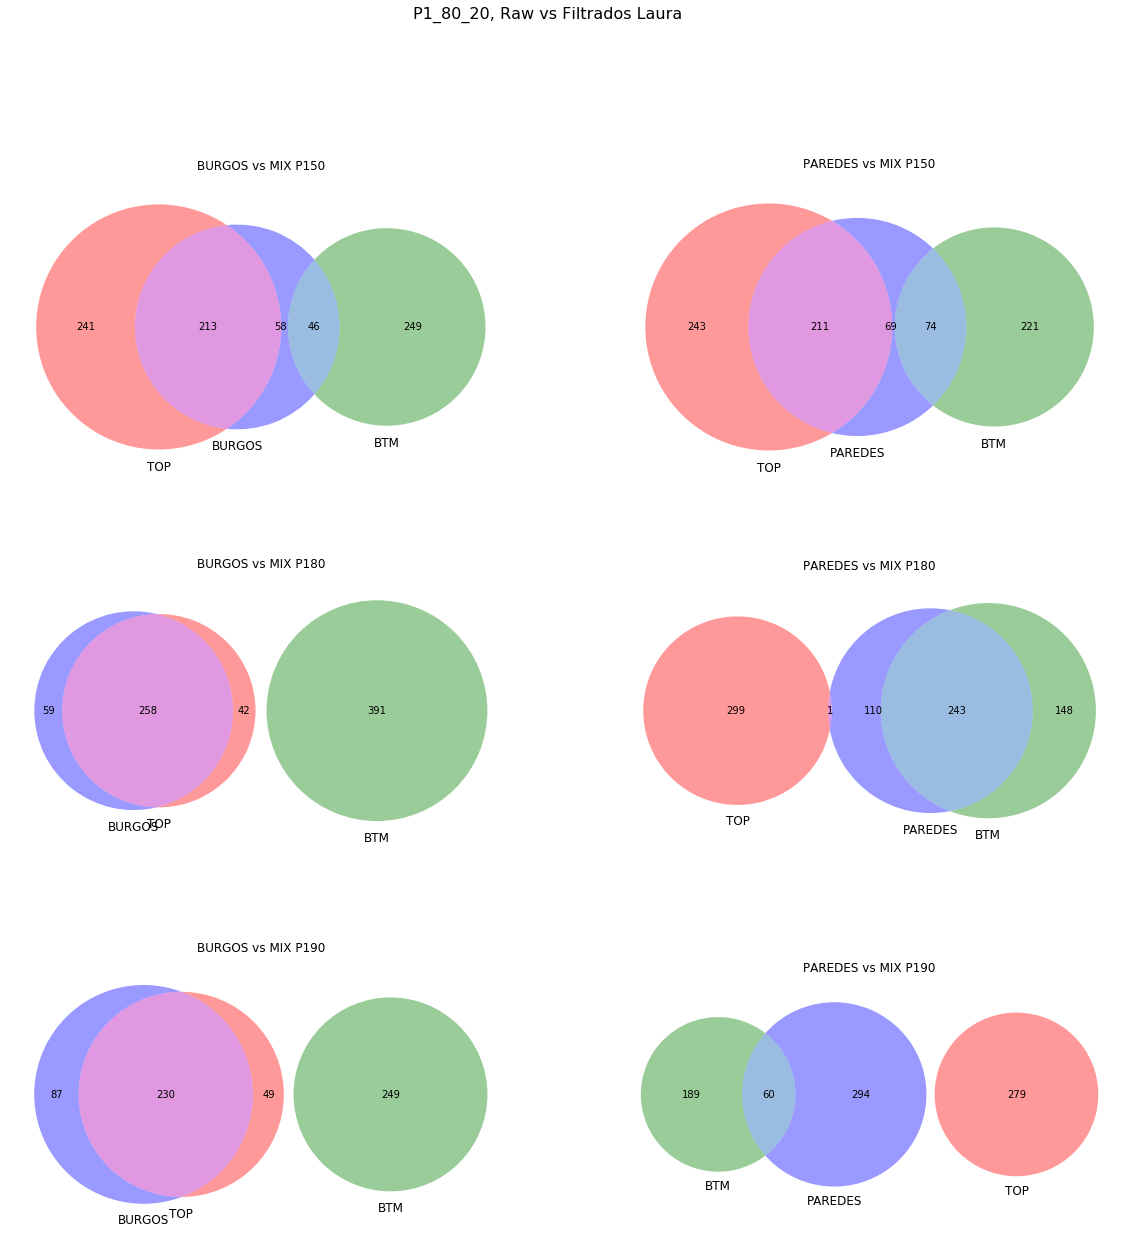

In [378]:
#plt.subplot(row, columns, plot_position)

plt.figure(figsize=(20,20))

plt.subplot(3, 2, 1)
plt.title("BURGOS vs MIX P150")
v = venn3([top_P150_set, btm_P150_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P150_set, btm_P150_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(3, 2, 2)
plt.title("PAREDES vs MIX P150")
v2 = venn3([top_P150_set, btm_P150_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))


plt.subplot(3, 2, 3)
plt.title("BURGOS vs MIX P180")
v = venn3([top_P180_set, btm_P180_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P180_set, btm_P180_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(3, 2, 4)
plt.title("PAREDES vs MIX P180")
v2 = venn3([top_P180_set, btm_P180_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.subplot(3, 2, 5)
plt.title("BURGOS vs MIX P190")
v = venn3([top_P190_set, btm_P190_set, B_exclusive], set_labels = ('TOP', 'BTM', 'BURGOS'), )
#c = venn3_circles([top_P180_set, btm_P180_set, B_exclusive], linestyle='dashed', linewidth=1, color="grey")

plt.subplot(3, 2, 6)
plt.title("PAREDES vs MIX P190")
v2 = venn3([top_P190_set, btm_P190_set, P_exclusive], set_labels = ('TOP', 'BTM', 'PAREDES'))
plt.suptitle('P1_80_20, Raw vs Filtrados Laura', fontsize=16, verticalalignment='bottom')

plt.savefig(os.path.join('img', 'P1_ALL.svg'), format="svg")
#plt.show()

# Check mixed linage 

In [380]:
def split_df_mean_todict(vcf_df):
    mean = vcf_df['AF'][vcf_df['AF'] < 1].mean(axis = 0)
    top_positions = vcf_df[(vcf_df['AF'] > mean) & (vcf_df['AF'] < 1)]
    top_positions_dict = top_positions.set_index('POS')['ALT'].to_dict()
    bottom_positions = vcf_df[vcf_df['AF'] < mean]
    bottom_positions_dict = bottom_positions.set_index('POS')['ALT'].to_dict()
    return top_positions_dict, bottom_positions_dict

In [395]:
PAIR180_dict = PAIR180_dsf.set_index('POS')['ALT'].to_dict()
PAIR190_dict = PAIR190_dsf.set_index('POS')['ALT'].to_dict()
PAIR150_dict = PAIR150_dsf.set_index('POS')['ALT'].to_dict()

In [396]:
get_lineage_coll(PAIR180_dict)
get_lineage_coll(PAIR190_dict)
get_lineage_coll(PAIR150_dict)

This samples belongs to linage 4
This samples belongs to linage 4
This samples belongs to linage 4


'4'

In [397]:
top_P180_dict, btm_P180_dict = split_df_mean_todict(PAIR180_dsf)
top_P190_dict, btm_P190_dict = split_df_mean_todict(PAIR190_dsf)
top_P150_dict, btm_P150_dict = split_df_mean_todict(PAIR150_dsf)
get_lineage_coll(top_P180_dict)
get_lineage_coll(top_P190_dict)
get_lineage_coll(top_P150_dict)
get_lineage_coll(btm_P180_dict)
get_lineage_coll(btm_P190_dict)
get_lineage_coll(btm_P150_dict)

This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown
This samples belongs to linage unknown


'unknown'